## Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import unyt

import os
from glob import glob
from pathlib import Path
from copy import copy


from velociraptor.observations import load_observation, load_observations
from velociraptor.observations.objects import ObservationalData
from swiftemulator.comparison.penalty import L2PenaltyCalculator, GaussianDataErrorsPercentFloorPenaltyCalculator, GaussianWeightedDataErrorsPercentFloorPenaltyCalculator


# For fitting model to data
from scipy.optimize import minimize
from random import choice as rand_choice

import emcee
import corner
import arviz
from scipy.stats import norm


# For loading in emulator
import dill

## Define useful functions

In [2]:
def emulator_model(x, pred_params, emulator):
    pred_y, pred_var = emulator.predict_values(x, pred_params)
    
    pred_std = np.sqrt(pred_var)
    pred_ccheck_std = np.abs(emulator.model_specification.sigma_ccheck * pred_y)
    pred_total = np.sqrt(pred_std**2 + pred_ccheck_std**2)
    
    return pred_y, pred_ccheck_std

In [4]:
def model(theta, x, emulator_info):
    params = emulator_info['params_best_node'].copy()

    for ii in range(len(theta)):
        key = list(params.keys())[ii]
        params[key] = theta[ii]

    val, err = emulator_model(x, params, emulator_info['emulator'])
    return val, err


def lnlike(theta, emulator_info):
    LnLike_val = 0
    for key, item in emulator_info.items():
        data = item['data_for_mcmc']
        x = data[0]
        y = data[1]
        yerr = data[2]
#         m, merr = model(theta, x, item['emulator'])
        m, merr = model(theta, x, item)
        
        
        ## Different likelihood function choices depending on what you want

    #    LnLike = sum(norm.logpdf(y, loc=m, scale=yerr))  # One way to get LnLike with scipy.stats
        LnLike = -0.5 * sum(np.power((y - m)*np.power(yerr,-1), 2))  # Get likelihood (assuming indepenent Gaussian error bars?)

#         LnLike = -0.5 * np.sum(np.power((y - m), 2))  # If no error bars on data
#         LnLike = -0.5 * np.sum(np.abs(y - m))  # If no error bars on data
#         LnLike = -0.5 * np.sum(np.power((y - m)/y, 2))  # If no error bars on data
#         LnLike = -0.5 * np.sum(np.abs((y - m)/y))  # If no error bars on data
#         LnLike = -np.sum((y - m)**2 / 0.5**2)
    
        
        # Likelihood from Kugel+23 (eqn 21/22/24)
#         LnLike_ = -(y - m)**2 / (yerr**2 + merr**2)
#         LnLike = np.sum(LnLike_) / len(x)


        # Using swift emulator penalty calculator
#         LnLike = -np.sum(item['penalty_calculator_for_mcmc'].penalty(independent=x, dependent=m, dependent_error=merr))
    
    
        LnLike_val += LnLike
    
#     print(LnLike_val)
    return LnLike_val


def within_limits(theta, emulator_info):
    result = True
    for key, item in emulator_info.items():
        for ii in range(len(theta)):
            result = result and (item['param_mins_arr'][ii] <= theta[ii] and theta[ii] <= item['param_maxs_arr'][ii])
    return result

def lnprior(theta, emulator_info):
    if within_limits(theta, emulator_info):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, emulator_info):
    lp = lnprior(theta, emulator_info)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, emulator_info)  # if lp not -inf, its 0, so this just returns likelihood

In [5]:
def sim_model(cali, theta, emulator_info):
    x_ = emulator_info['emulator'].model_values.model_values[cali_]['independent']
    y_ = emulator_info['emulator'].model_values.model_values[cali_]['dependent']
    yerr_ = emulator_info['emulator'].model_values.model_values[cali_]['dependent_error']
    return x_, y_, yerr_


def sim_lnlike(cali, theta, emulator_info):
    LnLike_val = 0
    for key, item in emulator_info.items():
        ## Choose to interpolate data rather than simulation
#         data = item['data_for_mcmc']
        data = item['data_interp']
        x = data[0]
        y = data[1]
        yerr = data[2]
#         m, merr = model(theta, x, item['emulator'])
        mx, my, myerr = sim_model(cali, theta, item)
    
    
        ## Get only interpolated data values that match to simulation points
        data_condition = np.logical_and(x >= min(mx), x <= max(mx))
        x = x[data_condition]
        y = y[data_condition]
        yerr = yerr[data_condition]
    
    
        ## Get only simulation values that match to interpolated data points
        model_condition = np.logical_and(mx >= min(x), mx <= max(x))
        mx = mx[model_condition]
        my = my[model_condition]
        myerr = myerr[model_condition]
    
        
        ## Different likelihood function choices depending on what you want

    #    LnLike = sum(norm.logpdf(y, loc=m, scale=yerr))  # One way to get LnLike with scipy.stats
        LnLike = -0.5 * sum(np.power((y - my)*np.power(yerr,-1), 2))  # Get likelihood (assuming indepenent Gaussian error bars?)

#         LnLike = -0.5 * np.sum(np.power((y - m), 2))  # If no error bars on data
#         LnLike = -0.5 * np.sum(np.abs(y - m))  # If no error bars on data
#         LnLike = -0.5 * np.sum(np.power((y - m)/y, 2))  # If no error bars on data
#         LnLike = -0.5 * np.sum(np.abs((y - m)/y))  # If no error bars on data
#         LnLike = -np.sum((y - m)**2 / 0.5**2)
    
        
        # Likelihood from Kugel+23 (eqn 21/22/24)
#         LnLike_ = -(y - m)**2 / (yerr**2 + merr**2)
#         LnLike = np.sum(LnLike_) / len(x)


        # Using swift emulator penalty calculator
#         LnLike = -np.sum(item['penalty_calculator_for_mcmc'].penalty(independent=x, dependent=my, dependent_error=myerr))
    
    
        LnLike_val += LnLike
    
#     print(LnLike_val)
    return LnLike_val


def sim_within_limits(theta, emulator_info):
    result = True
    for key, item in emulator_info.items():
        for ii in range(len(theta)):
            result = result and (item['param_mins_arr'][ii] <= theta[ii] and theta[ii] <= item['param_maxs_arr'][ii])
    return result

def sim_lnprior(theta, emulator_info):
    if sim_within_limits(theta, emulator_info):
        return 0.0
    else:
        return -np.inf
    
def sim_lnprob(cali, theta, emulator_info):
    lp = sim_lnprior(theta, emulator_info)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + sim_lnlike(cali, theta, emulator_info)  # if lp not -inf, its 0, so this just returns likelihood

## Load/calculate all relevant info for each emulator/observable

In [59]:
emulator_info = {
    'GSMF':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
        'cali_dir':'calibrations',
#         'obs_name':'allMstar_gsmf_log_data_0015',
        'obs_name':'gsmf_log_data_min10gal_0015_allMstar',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s50n512',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/gsmf/Bernardi+17/',
        'data_name':'bernardi17_z0_gsmf_log_data_big_error_corrected',
        'data_choice':'data_sim',
        'use_err':'max',
        'min_x_for_mcmc':8.5,
        'max_x_for_mcmc':15,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue', 'err_bar_or_band':'band'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red', 'err_bar_or_band':'band'},
        'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'bar'},
    },
    'Mbh-M*':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
        'cali_dir':'calibrations',
#         'obs_name':'allMstar_bhmsm_binned_log_median_0015',
        'obs_name':'bhmsm_binned_log_median_min10gal_0015_lowMstar8.2',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s50n512',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/bhmsm/KormendyHo2013/',
        'data_name':'kh13_bhmsm_log_fit_og',
#         'data_name':'kh13_bhmsm_log_data',
        'data_choice':'data_interp',
        'use_err':'max',
        'min_x_for_mcmc':8.5,
        'max_x_for_mcmc':15,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue', 'err_bar_or_band':'band'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red', 'err_bar_or_band':'band'},
        'plot_data':{'ls':'-', 'marker':None, 'color':'black', 'err_bar_or_band':'band'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'bar'},
    },
#     'Quenched Fraction':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
#         'cali_dir':'calibrations',
#         'obs_name':'lowMstar11_quenched_fraction_v2_0015_polynomial_degree_4',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s50n512',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/ssfr/gswlc-x2/',
#         'data_name':'gswlc-x2_ssfr_lowMstar11_quenched_fraction_v2',
#         'data_choice':'data_lim',
#         'use_err':'max',
#         'min_x_for_mcmc':1,
#         'max_x_for_mcmc':20,
#         'plot_sim':{'ls':'', 'marker':'o', 'color':'blue', 'err_bar_or_band':'bar'},
#         'plot_emu':{'ls':'', 'marker':'o', 'color':'red', 'err_bar_or_band':'bar'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'bar'},
#     },
#     'CSFH':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_32x_v2/',
#         'cali_dir':'calibrations',
#         'obs_name':'csfh_log_data',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s25n256',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/csfh/MD14/',
#         'data_name':'md14_csfh_log_data',
#         'data_choice':'data_lim',
#         'use_err':'max',
#         'min_x_for_mcmc':-1,
#         'max_x_for_mcmc':5,
#         'plot_sim':{'ls':'--', 'marker':None, 'color':'blue', 'err_bar_or_band':'band'},
#         'plot_emu':{'ls':'-', 'marker':None, 'color':'red', 'err_bar_or_band':'band'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'band'},
#     },
}

In [60]:
# Get all relevant info for each observable
for key, item in emulator_info.items():
    print(key)
    
    # Trained emulator
    with open(os.path.join(item['root_dir'], item['emulator_dir'], item['emulator_type']+'_'+item['obs_name']+'.pkl'), 'rb') as f:
        emulator = dill.load(f)
    item['emulator'] = emulator
    
    # Observational data
    observational_data = load_observations(os.path.join(item['data_dir'], item['data_name']+'.hdf5'))[0]
#     print(observational_data.x)
    
    sim_x_units = emulator.model_specification.sim_info['x_units']
    sim_y_units = emulator.model_specification.sim_info['y_units']
    data_x_units = observational_data.x_units
    data_y_units = observational_data.y_units
    
#     print(sim_y_units)
#     print(data_y_units)
    
    observational_data.x.convert_to_units(sim_x_units)
    observational_data.y.convert_to_units(sim_y_units)
    
#     observational_data = observational_data_[0]
#     print(observational_data)
    item['observational_data'] = observational_data
    
    
    # Penalty function
    sim_paths = [Path(x) for x in glob(os.path.join(item['root_dir'], item['cali_dir'], 'cali_*', 
                                                    item['snap_prefix']+'_'+item['obs_name']+'_'+item['snap_num']+'.hdf5')) 
                 if os.path.exists(x)]
    item['sim_paths'] = sim_paths
    

    penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=50,
                                                                                 sigma_max=100,
                                                                                 weight=100,
                                                                                 lower=min(observational_data.x),
                                                                                 upper=max(observational_data.x))
#     penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=0.01,
#                                                                                  sigma_max=0.1,
#                                                                                  weight=1,
#                                                                                  lower=min(observational_data.x),
#                                                                                  upper=max(observational_data.x))

    penalty_calculator.register_observation(observational_data,
                                log_independent=False,
                                log_dependent=False,
                                independent_units=observational_data.x_units,
                                dependent_units=observational_data.y_units)
    
    item['penalty_calculator'] = penalty_calculator
    
    
    
    # Get full range of x values that have been used in training emulator
    sim_x = []
    for cali in emulator.model_values.model_values:
        sim_x_curr = emulator.model_values[cali]['independent']
        for x_val in sim_x_curr:
            if x_val not in sim_x:
                sim_x.append(x_val)

    sim_x = np.array(np.sort(sim_x))
    item['sim_x'] = sim_x
    
    
    # Get "limited" range of x values that have been used in training emulator
    # ie. lower and upper limits on x values are ones that are common to all simulations
    sim_x_lim = []
    counter = 0
    for cali, item_ in emulator.model_values.items():
        sim_x_lim_curr = item_['independent']
        if counter==0:
            sim_x_lim = sim_x_lim_curr
        else:
            sim_x_lim = np.intersect1d(sim_x_lim, sim_x_lim_curr)
        counter += 1

    sim_x_lim = np.array(np.sort(sim_x_lim))
    item['sim_x_lim'] = sim_x_lim
    
    
    
    # Get just full range of data
    x = penalty_calculator.observation.x.value
#     xerr = penalty_calculator.observation.x_scatter.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
#     xerr = xerr[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]
    
    if item['use_err'] == 'max':
        data_full = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_full = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_full'] = data_full
    
    
    # Separate out data into x, y, yerr
    # Get only data that falls within chosen x range of simulation, but is still original data without interpolation
    x = penalty_calculator.observation.x.value
#     xerr = penalty_calculator.observation.x_scatter.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value
    
    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
#     xerr = xerr[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]

    range_condition = np.logical_and(x >= min(sim_x), x <= max(sim_x))
    x = x[range_condition]
#     xerr = xerr[range_condition]
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_sim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_sim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_sim'] = data_sim
    
    
    # Separate out data into x, y, yerr
    # Get only data that falls within limited x range of simulation, but is still original data without interpolation
    x = penalty_calculator.observation.x.value
#     xerr = penalty_calculator.observation.x_scatter.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value
    
    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
#     xerr = xerr[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]

    range_condition = np.logical_and(x >= min(sim_x_lim), x <= max(sim_x_lim))
    x = x[range_condition]
#     xerr = xerr[range_condition]
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_lim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_lim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_lim'] = data_lim
    
    
    # Separate out data into x, y, yerr
    # Get only data that corresponds to exact chosen x range of simulation
    # (Need to use GaussianDataErrorsPercentFloorPenaltyCalculator to do interpolation for this)
    x = sim_x
#     xerr = np.zeros()
    penalty_calculator.observation_interpolation()
    y = penalty_calculator.interpolator_values(x)
    yerr = penalty_calculator.error_interpolator_values(x)  # can only use for certain penalty calculators, eg. GaussianDataErrorsPercentFloorPenaltyCalculator

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr
        
    range_condition = np.logical_and(sim_x >= min(penalty_calculator.observation.x.value), 
                                     sim_x <= max(penalty_calculator.observation.x.value))
    x = x[range_condition]  # limit to within range of observational data
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_interp = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_interp = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_interp'] = data_interp
    
    
    
    # Separate out data into x, y, yerr
    # Get only data that corresponds to exact limited x range of simulation
    # (Need to use GaussianDataErrorsPercentFloorPenaltyCalculator to do interpolation for this)
    x = sim_x_lim
    penalty_calculator.observation_interpolation()
    y = penalty_calculator.interpolator_values(x)
    yerr = penalty_calculator.error_interpolator_values(x)  # can only use for certain penalty calculators, eg. GaussianDataErrorsPercentFloorPenaltyCalculator

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr
        
    range_condition = np.logical_and(sim_x_lim >= min(penalty_calculator.observation.x.value), 
                                     sim_x_lim <= max(penalty_calculator.observation.x.value))
    x = x[range_condition]  # limit to within range of observational data
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_interp_lim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_interp_lim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_interp_lim'] = data_interp_lim
    
    
    
    # Choose which data to use for MCMC
    try:
        data_choice = item[item['data_choice']]
    except:
        print('Invalid data choice')
        break
    range_condition = np.logical_and(data_choice[0] >= item['min_x_for_mcmc'], 
                                     data_choice[0] <= item['max_x_for_mcmc'])
    x = data_choice[0][range_condition]
    y = data_choice[1][range_condition]
    yerr = data_choice[2][range_condition]
    
    data_for_mcmc = (x, y, yerr)
    item['data_for_mcmc'] = data_for_mcmc
    
    
    
    
    # Limit observational data to data_for_mcmc
    item['observational_data_for_mcmc'] = copy(item['observational_data'])
    item['observational_data_for_mcmc'].associate_x(item['data_for_mcmc'][0]*item['observational_data'].x_units, 
                                           scatter=np.zeros(len(item['data_for_mcmc'][0]))*item['observational_data'].x_units, 
                                           comoving=item['observational_data'].x_comoving, 
                                           description=item['observational_data'].x_description)
    item['observational_data_for_mcmc'].associate_y(item['data_for_mcmc'][1]*item['observational_data'].y_units, 
                                           scatter=item['data_for_mcmc'][2]*item['observational_data'].y_units, 
                                           comoving=item['observational_data'].y_comoving, 
                                           description=item['observational_data'].y_description)
    
#     print(item['observational_data'].x)
#     print(item['observational_data'].x_description)
    
    
    # Re-initialize penalty calculator so it only considers data_for_mcmc
    penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=50,
                                                                                 sigma_max=100,
                                                                                 weight=100,
                                                                                 lower=min(item['observational_data_for_mcmc'].x),
                                                                                 upper=max(item['observational_data_for_mcmc'].x))
#     penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=0.01,
#                                                                                  sigma_max=0.1,
#                                                                                  weight=1,
#                                                                                  lower=min(observational_data.x),
#                                                                                  upper=max(observational_data.x))
#     penalty_calculator = L2PenaltyCalculator(offset=0.5,
#                                              lower=min(item['observational_data'].x),
#                                              upper=max(item['observational_data'].x))

    penalty_calculator.register_observation(item['observational_data_for_mcmc'],
                                log_independent=False,
                                log_dependent=False,
                                independent_units=item['observational_data_for_mcmc'].x_units,
                                dependent_units=item['observational_data_for_mcmc'].y_units)
    
    item['penalty_calculator_for_mcmc'] = penalty_calculator
    
    
    
    
    # Get full x range of both simulation and observational data (just for plotting purposes)
    x_lo_full = min(min(sim_x), min(data_full[0]))
    x_hi_full = max(max(sim_x), max(data_full[0]))
    
    N_full = 100
    x_full = np.linspace(x_lo_full, x_hi_full, N_full)
    item['x_full'] = x_full
    
    
    
    # Check which input simulation best fits the observational data
    all_penalties = item['penalty_calculator_for_mcmc'].penalties(emulator.model_values, np.mean)
#     print(all_penalties)

    all_penalties_array = []
    node_number = []
    for key_penalty in all_penalties.keys():
        all_penalties_array.append(all_penalties[key_penalty])
        node_number.append(key_penalty)

#     print(all_penalties_array)
#     print(np.min(all_penalties_array))
    best_node = node_number[np.argmin(all_penalties_array)]
#     best_node = node_number[np.argmax(all_penalties_array)]
    params_best_node = emulator.model_parameters[best_node].copy()
    
    item['best_node'] = best_node
    item['params_best_node'] = params_best_node
#     print(best_node)
#     print(params_best_node)
    
    
    # Get min and max values of each parameter that go into original simulations
    # They will be the MCMC parameter limits
    param_mins_arr = []
    param_maxs_arr = []
    param_mins = {}
    param_maxs = {}
    
    for param_, param_limits_ in zip(emulator.model_specification.parameter_names, emulator.model_specification.parameter_limits):
        param_mins_arr.append(param_limits_[0])
        param_maxs_arr.append(param_limits_[1])
    param_mins_arr = np.array(param_mins_arr, float)
    param_maxs_arr = np.array(param_maxs_arr, float)
    
    # If you want to specify other flat parameter priors for the MCMC
#     param_mins_arr = [0.5, 5.0, 0.00001, 6.5]
#     param_maxs_arr = [5.0, 13.0, 0.008, 8.0]

    for param_, param_limits_ in zip(emulator.model_specification.parameter_names, emulator.model_specification.parameter_limits):
        param_mins[param_] = param_limits_[0]
        param_maxs[param_] = param_limits_[1]
    
    item['param_mins'] = param_mins
    item['param_maxs'] = param_maxs
    item['param_mins_arr'] = param_mins_arr
    item['param_maxs_arr'] = param_maxs_arr
    
    
    
    print("DONE")
    print()

GSMF
DONE

Mbh-M*
DONE



In [61]:
emulator_info

{'GSMF': {'root_dir': '/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
  'cali_dir': 'calibrations',
  'obs_name': 'gsmf_log_data_min10gal_0015_allMstar',
  'emulator_type': 'emulator',
  'snap_prefix': 'simba_s50n512',
  'snap_num': '0015',
  'emulator_dir': 'emulators',
  'data_dir': '/home/b/babul/aspadawe/data/observations/gsmf/Bernardi+17/',
  'data_name': 'bernardi17_z0_gsmf_log_data_big_error_corrected',
  'data_choice': 'data_sim',
  'use_err': 'max',
  'min_x_for_mcmc': 8.5,
  'max_x_for_mcmc': 15,
  'plot_sim': {'ls': '--',
   'marker': None,
   'color': 'blue',
   'err_bar_or_band': 'band'},
  'plot_emu': {'ls': '-',
   'marker': None,
   'color': 'red',
   'err_bar_or_band': 'band'},
  'plot_data': {'ls': '',
   'marker': 'o',
   'color': 'black',
   'err_bar_or_band': 'bar'},
  'emulator': GaussianProcessEmulator(kernel=ConstantKernel(log_constant=-1.6094379124341003, ndim=5, axes=array([0, 1, 2, 3, 4])) * ExpSquaredK

In [62]:
emulator_info['GSMF']['emulator'].model_specification

ModelSpecification(number_of_parameters=4, parameter_names=['SIMBAFeedback:FIRE_velocity_normalization', 'SIMBAFeedback:FIRE_eta_normalization', 'SIMBAAGN:torque_accretion_norm', 'SIMBAAGN:jet_mass_min_Msun'], parameter_limits=[[0.6077018454057271, 4.9328691717704976], [5.06336426684861, 12.75773436560765], [0.00015687568681911943, 0.009887196909271688], [7.004113742600612, 7.982601455642615]], parameter_printable_names=['$v_{a}$', '$\\eta_{0}$', '$\\varepsilon_{\\rm torque}$', '$\\log_{10}$ $M_{\\rm BH, lim}/M_{\\rm \\odot}$'])

In [63]:
len(emulator_info['Mbh-M*']['data_interp'][0])

12

GSMF
cali_0025
{'SIMBAFeedback:FIRE_velocity_normalization': 4.342729786319703, 'SIMBAFeedback:FIRE_eta_normalization': 9.890361171833192, 'SIMBAAGN:torque_accretion_norm': 0.0015035993220772544, 'SIMBAAGN:jet_mass_min_Msun': 7.9529521605643065}


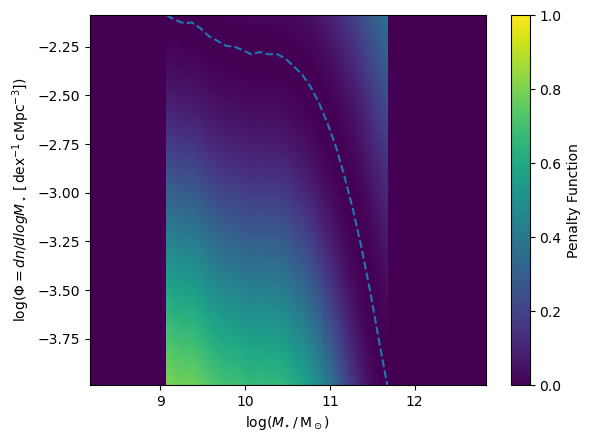

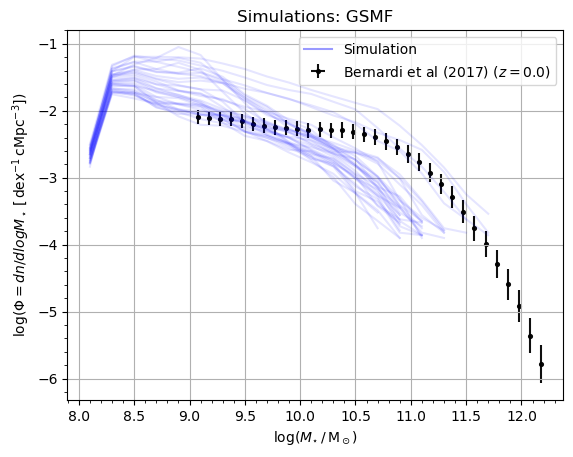

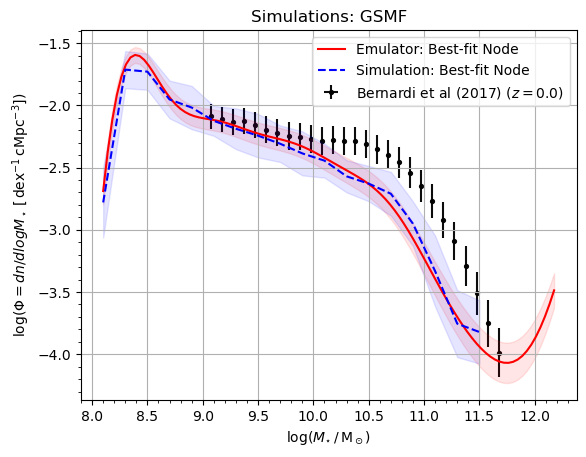

Mbh-M*
cali_0024
{'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


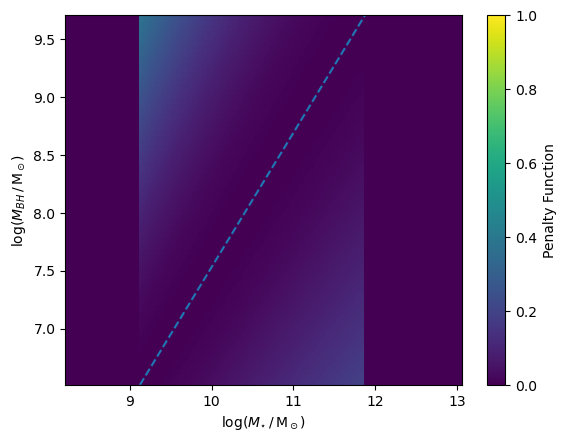

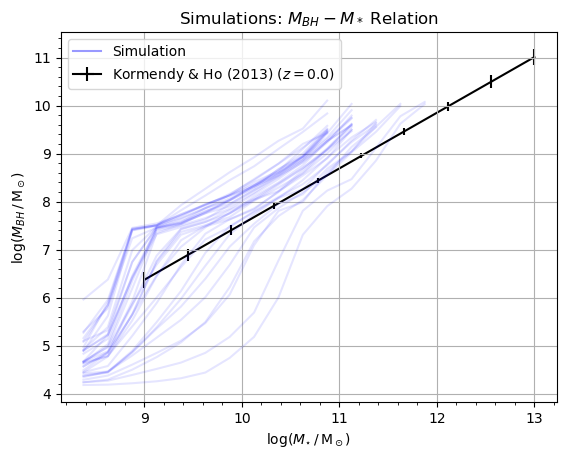

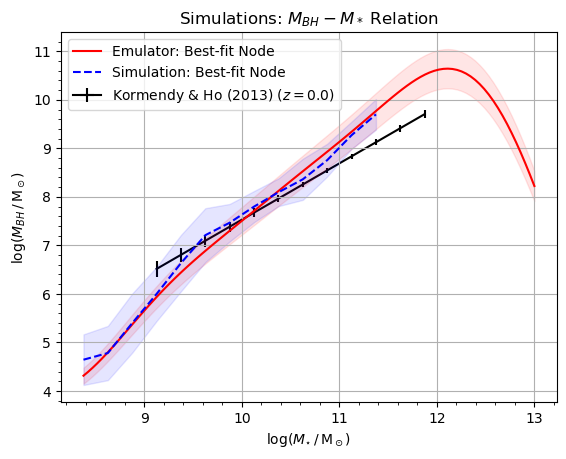

In [64]:
## Plot observational data and use penalty calculator to determine best-fit simulations individually (ie. not jointly)
## Penalty calculator has issues, so do not always trust this

for key, item in emulator_info.items():
    print(key)
    print(item['best_node'])
    print(item['params_best_node'])
    
#     item['penalty_calculator'].plot_penalty(0.9*min(item['penalty_calculator'].observation.x),
#                                             1.1*max(item['penalty_calculator'].observation.x),
#                                             min(item['penalty_calculator'].observation.y),
#                                             max(item['penalty_calculator'].observation.y),
#                                             item['data_name'],
#                                             x_label=item['emulator'].model_specification.sim_info['X_LABEL'],
#                                             y_label=item['emulator'].model_specification.sim_info['Y_LABEL'],
#                                             resolution=128)
    
    item['penalty_calculator_for_mcmc'].plot_penalty(0.9*min(item['penalty_calculator_for_mcmc'].observation.x),
                                            1.1*max(item['penalty_calculator_for_mcmc'].observation.x),
                                            min(item['penalty_calculator_for_mcmc'].observation.y),
                                            max(item['penalty_calculator_for_mcmc'].observation.y),
#                                             item['data_name'],
                                            item['penalty_calculator_for_mcmc'].observation.name,
                                            x_label=item['penalty_calculator_for_mcmc'].observation.x_description,
                                            y_label=item['penalty_calculator_for_mcmc'].observation.y_description,
                                            resolution=128)
    
    plt.show()
    
    
    

    
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    # Plot simulated observables over observational data
    plt.clf()
    
#     item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']
        
        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], 
                 color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    
    item['observational_data_for_mcmc'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
    
    
    pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node', 
                     color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    elif item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    if item['plot_sim']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
                     item['emulator'].model_values[item['best_node']]['dependent'],
                     yerr=item['emulator'].model_values[item['best_node']]['dependent_error'],
                     label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
                     ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
    elif item['plot_sim']['err_bar_or_band'] == 'band':
        plt.plot(item['emulator'].model_values[item['best_node']]['independent'],
                 item['emulator'].model_values[item['best_node']]['dependent'],
                 label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
        plt.fill_between(item['emulator'].model_values[item['best_node']]['independent'],
                         item['emulator'].model_values[item['best_node']]['dependent']-item['emulator'].model_values[item['best_node']]['dependent_error'],
                         item['emulator'].model_values[item['best_node']]['dependent']+item['emulator'].model_values[item['best_node']]['dependent_error'], 
                         alpha=0.1, color=item['plot_sim']['color'])

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Find best simulations by looking at individual likelihoods

GSMF
Best simulation: cali_0025
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.342729786319703, 'SIMBAFeedback:FIRE_eta_normalization': 9.890361171833192, 'SIMBAAGN:torque_accretion_norm': 0.0015035993220772544, 'SIMBAAGN:jet_mass_min_Msun': 7.9529521605643065}


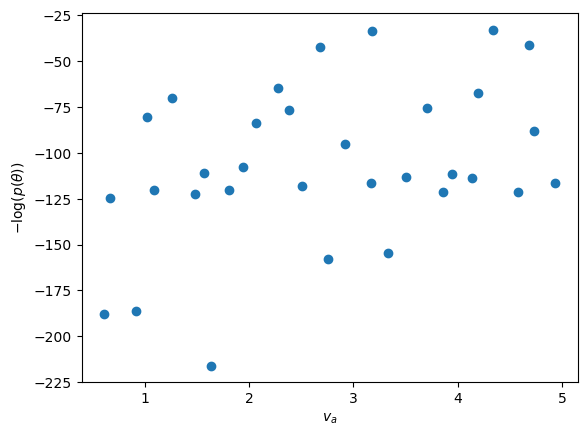

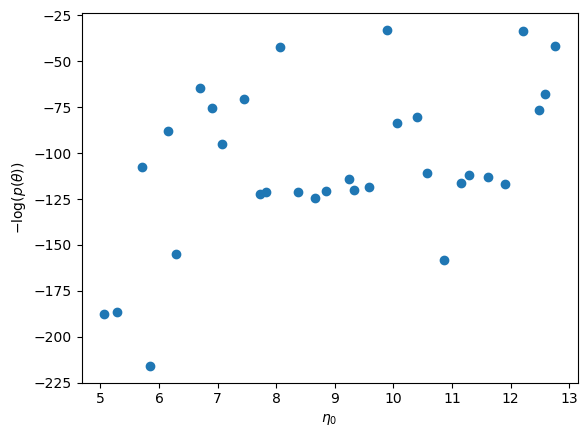

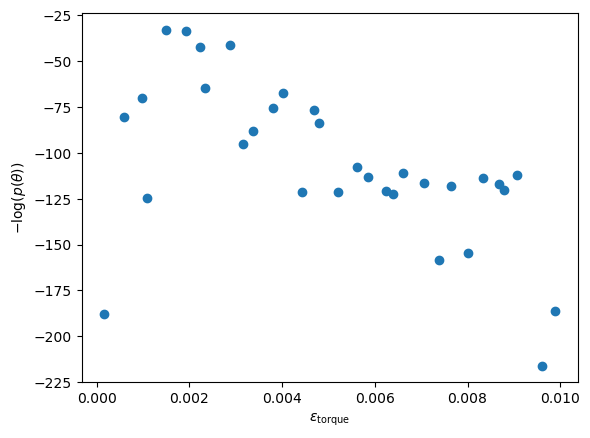

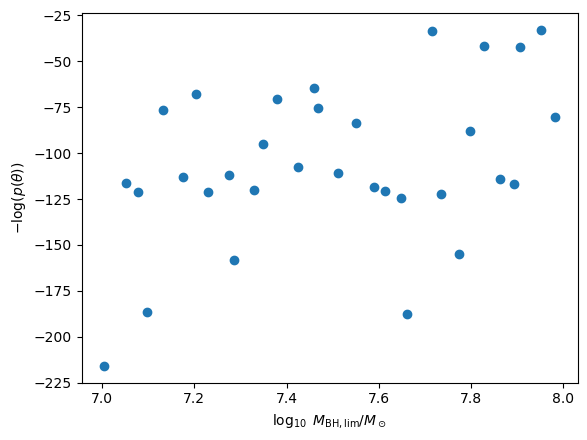


Mbh-M*
Best simulation: cali_0024
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


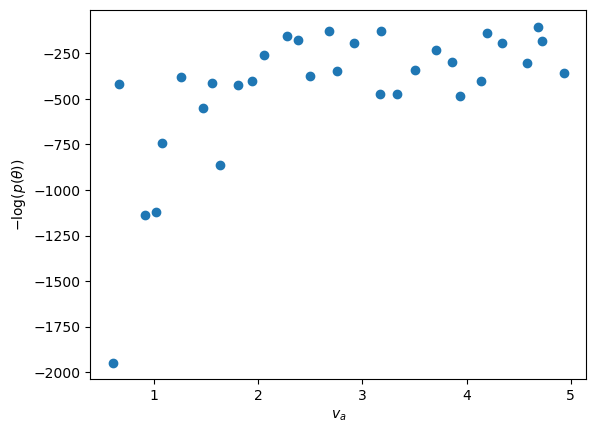

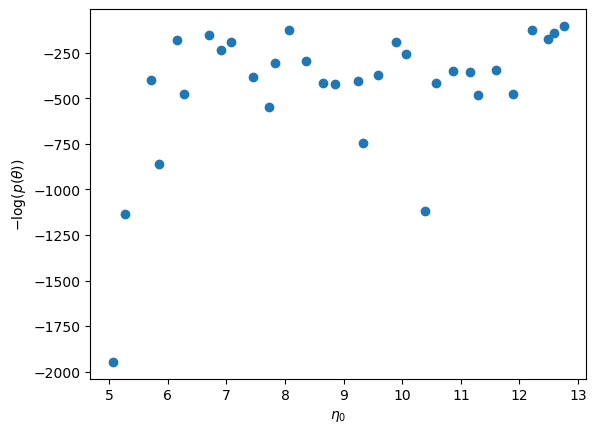

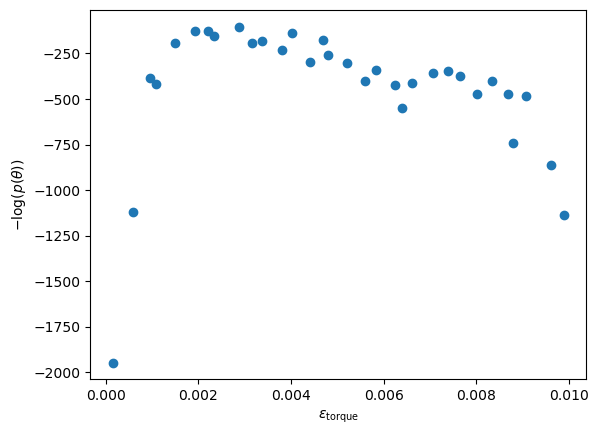

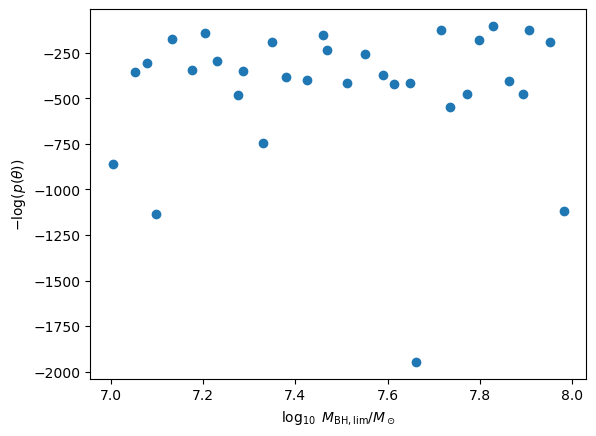


Quenched Fraction
Best simulation: cali_0003
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.727477736838244, 'SIMBAFeedback:FIRE_eta_normalization': 6.151178263359965, 'SIMBAAGN:torque_accretion_norm': 0.0033789370604987187, 'SIMBAAGN:jet_mass_min_Msun': 7.797660082334008}


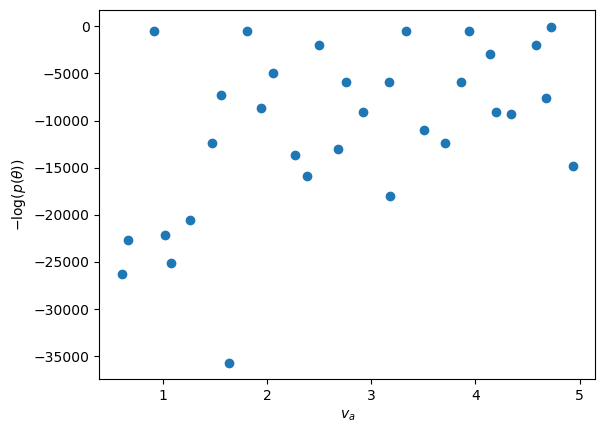

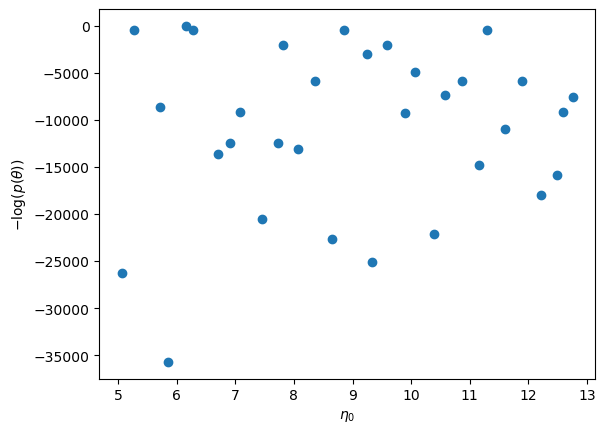

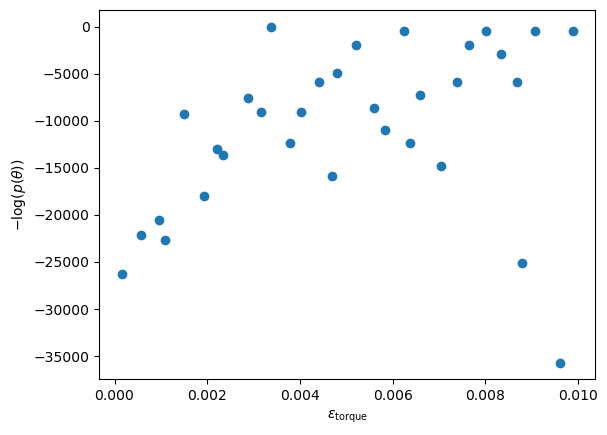

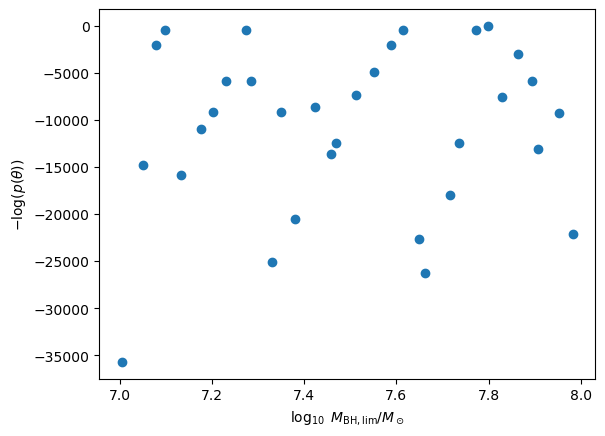

In [42]:
# Find best-fit simulations individually (ie. not jointly), but using my likelihood definition, which does not have issues

best_sim_ind_dict = {}
params_best_sim_ind_dict = {}

for key, info in emulator_info.items():
    print(key)

    sim_calis = []
    sim_thetas = []
    sim_likelihood = []
    for cali_, params_ in info['emulator'].model_parameters.model_parameters.items():
        theta_ = np.array(list(params_.values()))
    #     print(cali_)
    #     print(theta_)
        sim_calis.append(cali_)
        sim_thetas.append(theta_)
        sim_likelihood.append(sim_lnprob(cali_, theta_, {key:info}))

    sim_likelihood = np.array(sim_likelihood)

    best_sim_ind = sim_calis[np.argmax(sim_likelihood)]
    params_best_sim_ind = info['emulator'].model_parameters[best_sim_ind].copy()
    best_sim_ind_dict[key] = best_sim_ind
    params_best_sim_ind_dict[key] = params_best_sim_ind
    print('Best simulation:', best_sim_ind)
    print('Best simulation parameters:', params_best_sim_ind)

    sim_thetas_arr = np.zeros((len(sim_thetas), len(sim_thetas[0])))
    for ii in range(len(sim_thetas)):
        theta_ = sim_thetas[ii]
        sim_thetas_arr[ii,:] = theta_

    for jj in range(info['emulator'].model_specification.number_of_parameters):
    #     plt.hist(sim_thetas_arr[:,jj])
        plt.scatter(sim_thetas_arr[:,jj], sim_likelihood)
    #     plt.bar(sim_thetas_arr[:,jj], sim_likelihood)
        plt.xlabel(r'%s' % info['emulator'].model_specification.parameter_printable_names[jj])
        plt.ylabel(r'$-\log(p(\theta))$')
        plt.show()
        
    print()

GSMF

Best individual simulation: cali_0025
Best individual simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.342729786319703, 'SIMBAFeedback:FIRE_eta_normalization': 9.890361171833192, 'SIMBAAGN:torque_accretion_norm': 0.0015035993220772544, 'SIMBAAGN:jet_mass_min_Msun': 7.9529521605643065}


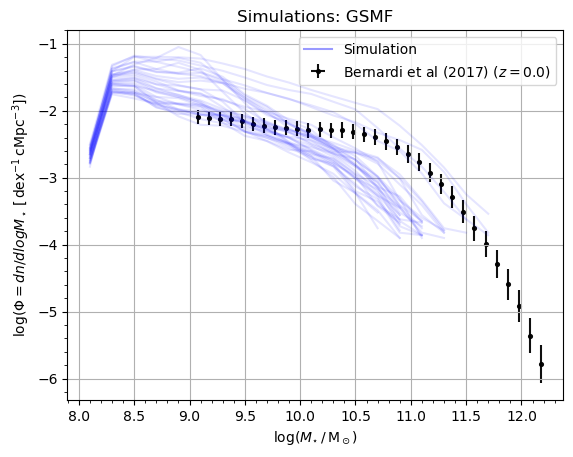

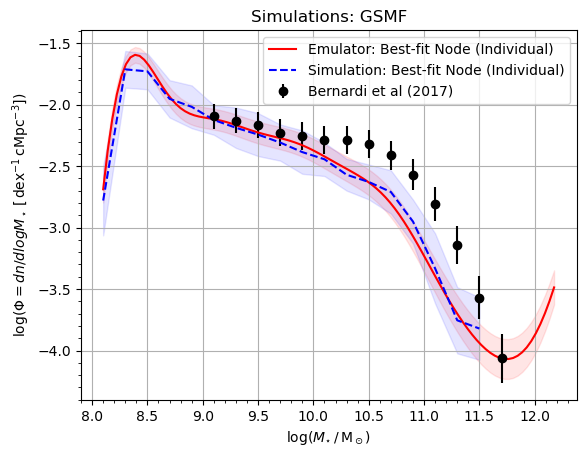

Mbh-M*

Best individual simulation: cali_0024
Best individual simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


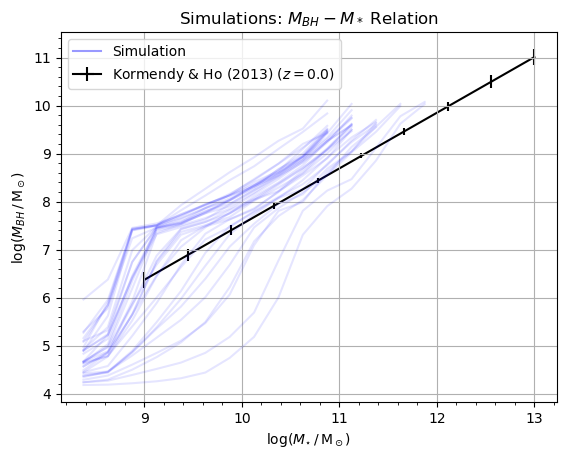

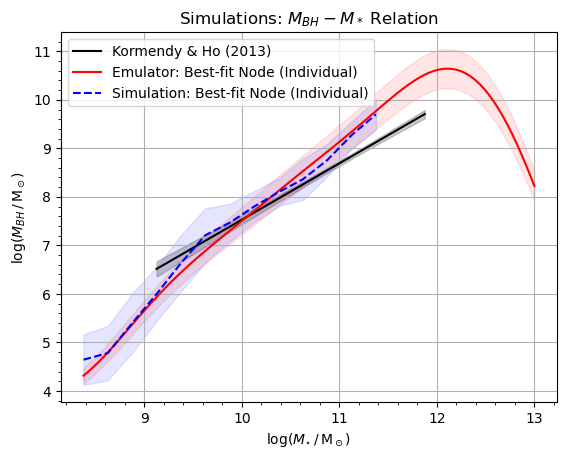

Quenched Fraction

Best individual simulation: cali_0003
Best individual simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.727477736838244, 'SIMBAFeedback:FIRE_eta_normalization': 6.151178263359965, 'SIMBAAGN:torque_accretion_norm': 0.0033789370604987187, 'SIMBAAGN:jet_mass_min_Msun': 7.797660082334008}


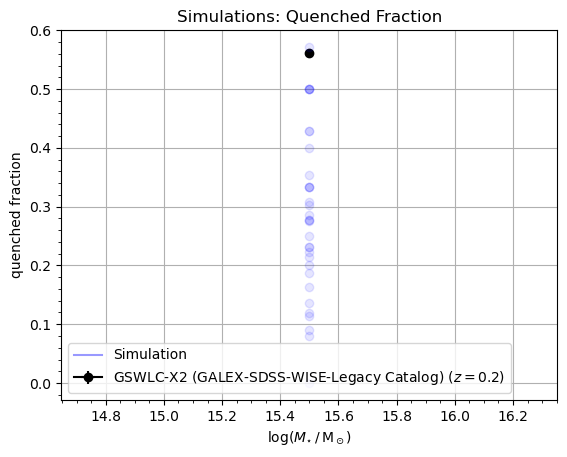

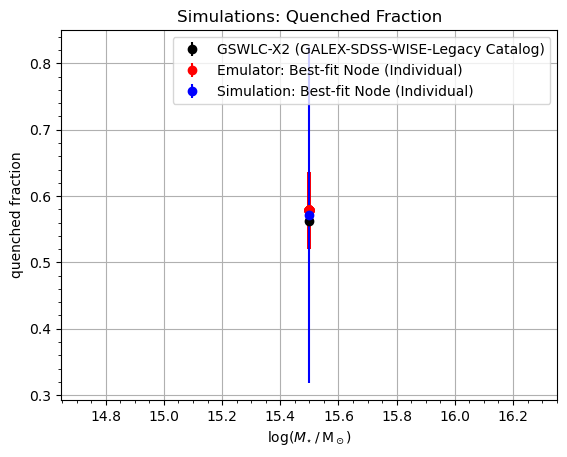

In [43]:
## Plot these best-fit simulations with their observational data

for key, item in emulator_info.items():
    print(key)
    print()
    
    print('Best individual simulation:', best_sim_ind_dict[key])
    print('Best individual simulation parameters:', params_best_sim_ind_dict[key])
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    
    
    
    
    # Plot simulated observables over observational data
    plt.clf()
    
#     item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']
        
        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], 
                 color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    
#     item['observational_data_for_mcmc'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    if item['plot_data']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['data_interp'][0], item['data_interp'][1], yerr=item['data_interp'][2], 
                     color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                     label=item['observational_data'].citation)
    elif item['plot_data']['err_bar_or_band'] == 'band':
        plt.plot(item['data_interp'][0], item['data_interp'][1],
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
                 marker=item['plot_data']['marker'], label=item['observational_data'].citation)
        plt.fill_between(item['data_interp'][0], 
                         item['data_interp'][1] - item['data_interp'][2], 
                         item['data_interp'][1] + item['data_interp'][2], 
                         color=item['plot_data']['color'], alpha=0.2)
    
    
#     pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
    
#     if item['plot_emu']['err_bar_or_band'] == 'bar':
#         plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node', 
#                      color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#     elif item['plot_emu']['err_bar_or_band'] == 'band':
#         plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
#                  color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#         plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
#     if item['plot_sim']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
#                      item['emulator'].model_values[item['best_node']]['dependent'],
#                      yerr=item['emulator'].model_values[item['best_node']]['dependent_error'],
#                      label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                      ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#     elif item['plot_sim']['err_bar_or_band'] == 'band':
#         plt.plot(item['emulator'].model_values[item['best_node']]['independent'],
#                  item['emulator'].model_values[item['best_node']]['dependent'],
#                  label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                  ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#         plt.fill_between(item['emulator'].model_values[item['best_node']]['independent'],
#                          item['emulator'].model_values[item['best_node']]['dependent']-item['emulator'].model_values[item['best_node']]['dependent_error'],
#                          item['emulator'].model_values[item['best_node']]['dependent']+item['emulator'].model_values[item['best_node']]['dependent_error'], 
#                          alpha=0.1, color=item['plot_sim']['color'])
        
        
        
    
    pred_y, pred_err = emulator_model(pred_x, params_best_sim_ind_dict[key], item['emulator'])
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node (Individual)', 
                     color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    elif item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node (Individual)', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    if item['plot_sim']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['emulator'].model_values[best_sim_ind_dict[key]]['independent'], 
                     item['emulator'].model_values[best_sim_ind_dict[key]]['dependent'],
                     yerr=item['emulator'].model_values[best_sim_ind_dict[key]]['dependent_error'],
                     label='Simulation: Best-fit Node (Individual)', color=item['plot_sim']['color'], 
                     ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
    elif item['plot_sim']['err_bar_or_band'] == 'band':
        plt.plot(item['emulator'].model_values[best_sim_ind_dict[key]]['independent'],
                 item['emulator'].model_values[best_sim_ind_dict[key]]['dependent'],
                 label='Simulation: Best-fit Node (Individual)', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
        plt.fill_between(item['emulator'].model_values[best_sim_ind_dict[key]]['independent'],
                         item['emulator'].model_values[best_sim_ind_dict[key]]['dependent']-item['emulator'].model_values[best_sim_ind_dict[key]]['dependent_error'],
                         item['emulator'].model_values[best_sim_ind_dict[key]]['dependent']+item['emulator'].model_values[best_sim_ind_dict[key]]['dependent_error'], 
                         alpha=0.1, color=item['plot_sim']['color'])
        
        

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Find best simulation by looking at joint likelihood

Best simulation: cali_0024
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


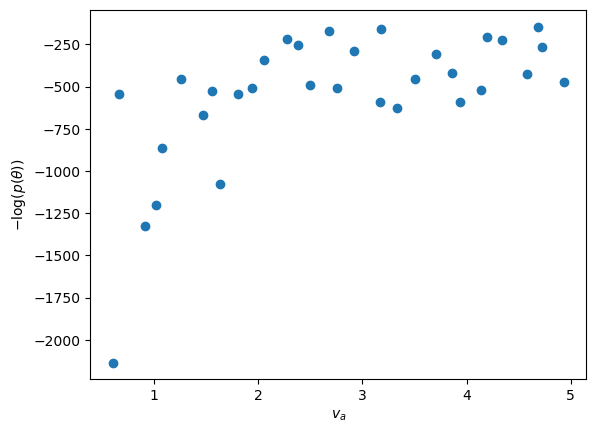

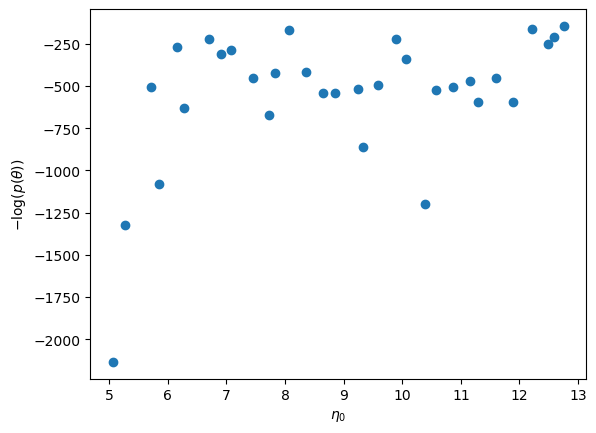

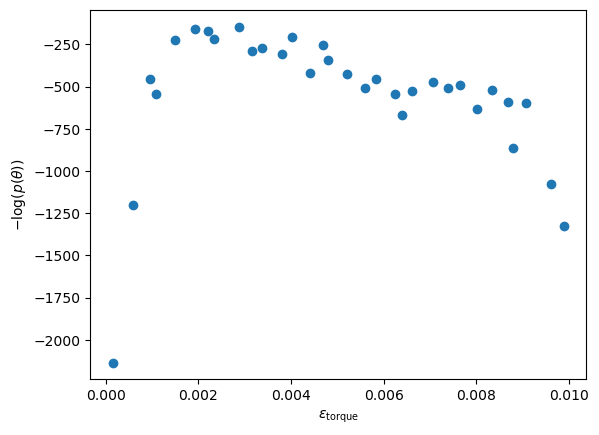

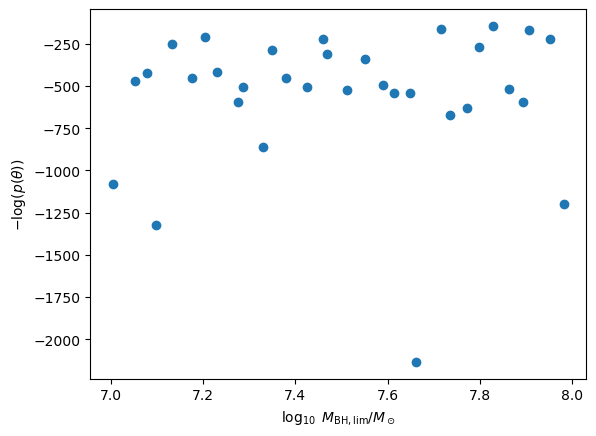

In [65]:
## Find single best-fit simulation with all observational datasets jointly
## This is what probably should be used as the initial parameters for the MCMC

sim_calis = []
sim_thetas = []
sim_likelihood = []
for cali_, params_ in emulator_info[list(emulator_info.keys())[0]]['emulator'].model_parameters.model_parameters.items():
    theta_ = np.array(list(params_.values()))
#     print(cali_)
#     print(theta_)
    sim_calis.append(cali_)
    sim_thetas.append(theta_)
    sim_likelihood.append(sim_lnprob(cali_, theta_, emulator_info))
    
sim_likelihood = np.array(sim_likelihood)

best_sim = sim_calis[np.argmax(sim_likelihood)]
params_best_sim = emulator_info[list(emulator_info.keys())[0]]['emulator'].model_parameters[best_sim].copy()
print('Best simulation:', best_sim)
print('Best simulation parameters:', params_best_sim)

sim_thetas_arr = np.zeros((len(sim_thetas), len(sim_thetas[0])))
for ii in range(len(sim_thetas)):
    theta_ = sim_thetas[ii]
    sim_thetas_arr[ii,:] = theta_
    
for jj in range(emulator_info[list(emulator_info.keys())[0]]['emulator'].model_specification.number_of_parameters):
#     plt.hist(sim_thetas_arr[:,jj])
    plt.scatter(sim_thetas_arr[:,jj], sim_likelihood)
#     plt.bar(sim_thetas_arr[:,jj], sim_likelihood)
    plt.xlabel(r'%s' % emulator_info[list(emulator_info.keys())[0]]['emulator'].model_specification.parameter_printable_names[jj])
    plt.ylabel(r'$-\log(p(\theta))$')
    plt.show()

Best simulation: cali_0024
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}

GSMF



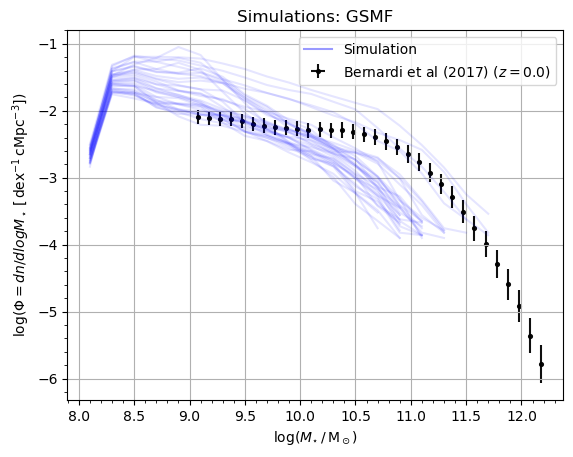

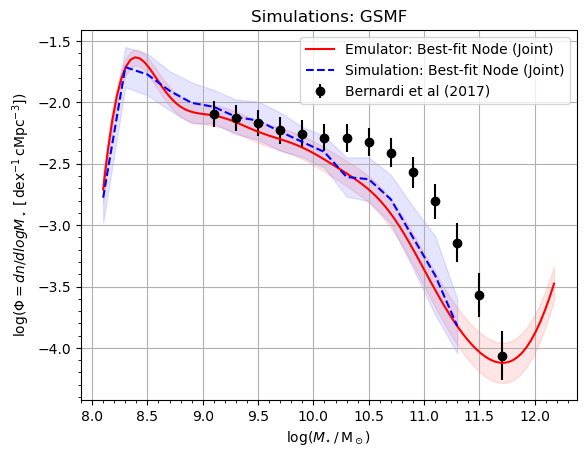

Mbh-M*



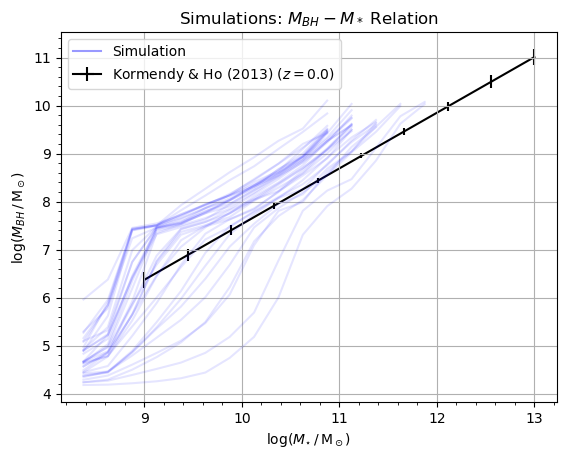

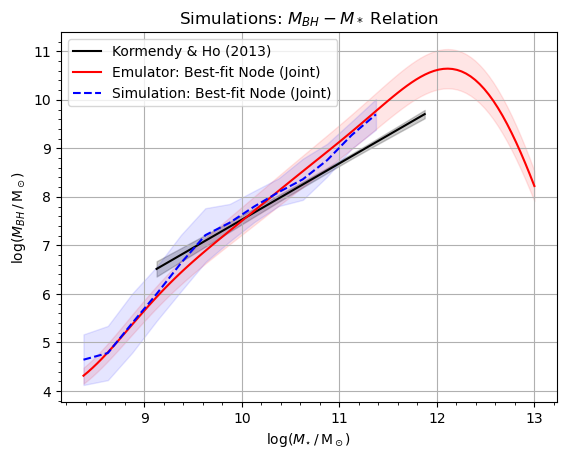

In [66]:
## Plot this best-fit simulation

print('Best simulation:', best_sim)
print('Best simulation parameters:', params_best_sim)
print()

for key, item in emulator_info.items():
    print(key)
    print()
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    
    
    
    
    # Plot simulated observables over observational data
    plt.clf()
    
#     item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']
        
        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], 
                 color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    
#     item['observational_data_for_mcmc'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    if item['plot_data']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['data_interp'][0], item['data_interp'][1], yerr=item['data_interp'][2], 
                     color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                     label=item['observational_data'].citation)
    elif item['plot_data']['err_bar_or_band'] == 'band':
        plt.plot(item['data_interp'][0], item['data_interp'][1],
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
                 marker=item['plot_data']['marker'], label=item['observational_data'].citation)
        plt.fill_between(item['data_interp'][0], 
                         item['data_interp'][1] - item['data_interp'][2], 
                         item['data_interp'][1] + item['data_interp'][2], 
                         color=item['plot_data']['color'], alpha=0.2)
    
    
#     pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
    
#     if item['plot_emu']['err_bar_or_band'] == 'bar':
#         plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node', 
#                      color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#     elif item['plot_emu']['err_bar_or_band'] == 'band':
#         plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
#                  color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#         plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
#     if item['plot_sim']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
#                      item['emulator'].model_values[item['best_node']]['dependent'],
#                      yerr=item['emulator'].model_values[item['best_node']]['dependent_error'],
#                      label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                      ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#     elif item['plot_sim']['err_bar_or_band'] == 'band':
#         plt.plot(item['emulator'].model_values[item['best_node']]['independent'],
#                  item['emulator'].model_values[item['best_node']]['dependent'],
#                  label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                  ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#         plt.fill_between(item['emulator'].model_values[item['best_node']]['independent'],
#                          item['emulator'].model_values[item['best_node']]['dependent']-item['emulator'].model_values[item['best_node']]['dependent_error'],
#                          item['emulator'].model_values[item['best_node']]['dependent']+item['emulator'].model_values[item['best_node']]['dependent_error'], 
#                          alpha=0.1, color=item['plot_sim']['color'])
        
        
        
    
    pred_y, pred_err = emulator_model(pred_x, params_best_sim, item['emulator'])
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node (Joint)', 
                     color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    elif item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node (Joint)', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    if item['plot_sim']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['emulator'].model_values[best_sim]['independent'], 
                     item['emulator'].model_values[best_sim]['dependent'],
                     yerr=item['emulator'].model_values[best_sim]['dependent_error'],
                     label='Simulation: Best-fit Node (Joint)', color=item['plot_sim']['color'], 
                     ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
    elif item['plot_sim']['err_bar_or_band'] == 'band':
        plt.plot(item['emulator'].model_values[best_sim]['independent'],
                 item['emulator'].model_values[best_sim]['dependent'],
                 label='Simulation: Best-fit Node (Joint)', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
        plt.fill_between(item['emulator'].model_values[best_sim]['independent'],
                         item['emulator'].model_values[best_sim]['dependent']-item['emulator'].model_values[best_sim]['dependent_error'],
                         item['emulator'].model_values[best_sim]['dependent']+item['emulator'].model_values[best_sim]['dependent_error'], 
                         alpha=0.1, color=item['plot_sim']['color'])
        
        

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Run joint MCMC on all models/observational data

In [67]:
## Initial parameter estimates for MCMC

## Starting from mean best-fit parameters from penalty calculator
# initial_opt = np.zeros(len(emulator_info[list(emulator_info.keys())[0]]['params_best_node'].values())).copy()
# opt_count = 0
# for key, item in emulator_info.items():
#     opt_count += 1
#     initial_opt += np.array(list(item['params_best_node'].values()))
# initial_opt /= opt_count

## Starting from one of the best-fit parameters from penalty calculator
# initial_opt = copy(np.array(list(emulator_info[list(emulator_info.keys())[1]]['params_best_node'].values())))

## Starting from the best-fit parameters from the joint likelihood of the simulations
initial_opt = copy(np.array(list(params_best_sim.values())))

## If want to start from random set of parameters
# all_params = []
# for cali_, params_ in emulator_info[list(emulator_info.keys())[0]]['emulator'].model_parameters.model_parameters.items():
# #     print(cali_)
#     all_params.append(np.array(list(params_.values())))
# # print(all_params)
# initial_opt = rand_choice(all_params)

print(initial_opt)

[4.68029777e+00 1.27577344e+01 2.87043009e-03 7.82954153e+00]


In [68]:
# Get initial estimate of parameters from scipy optimizer if want to (kind of unnecessary)
np.random.seed(42)
nll = lambda *args: -lnlike(*args)

soln = minimize(nll, initial_opt, args=emulator_info)
print(soln)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 325.9943768108632
        x: [ 4.680e+00  1.276e+01  2.160e-03  7.830e+00]
      nit: 5
      jac: [ 0.000e+00  0.000e+00  8.303e-02  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
            [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00  3.094e-09  0.000e+00]
            [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
     nfev: 337
     njev: 65


In [69]:
# Parameters for MCMC run
# if within_limits(soln.x, emulator_info):
#     initial_mcmc = soln.x
# else:
#     initial_mcmc = initial_opt
initial_mcmc = initial_opt
print(initial_mcmc)
ndim = len(initial_mcmc)
niter = 10000
nwalkers = 32
p0 = [np.array(initial_mcmc) + (-1)**i * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

[4.68029777e+00 1.27577344e+01 2.87043009e-03 7.82954153e+00]


In [70]:
print("Prior lower bounds:", emulator_info[list(emulator_info.keys())[0]]['param_mins'])
print("Prior upper bounds:", emulator_info[list(emulator_info.keys())[0]]['param_maxs'])

Prior lower bounds: {'SIMBAFeedback:FIRE_velocity_normalization': 0.6077018454057271, 'SIMBAFeedback:FIRE_eta_normalization': 5.06336426684861, 'SIMBAAGN:torque_accretion_norm': 0.00015687568681911943, 'SIMBAAGN:jet_mass_min_Msun': 7.004113742600612}
Prior upper bounds: {'SIMBAFeedback:FIRE_velocity_normalization': 4.9328691717704976, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.009887196909271688, 'SIMBAAGN:jet_mass_min_Msun': 7.982601455642615}


In [71]:
# Function for running production iterations of MCMC
def main(p0, nwalkers, niter, ndim, lnprob, emulator_info):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=emulator_info)

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)
    print("Done")

    return sampler, pos, prob, state

In [72]:
# Execute MCMC
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, [emulator_info])

Running production...


  0%|          | 0/10000 [00:00<?, ?it/s]/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [06:47<00:00, 24.54it/s]

Done


Text(0.5, 0, 'step number')

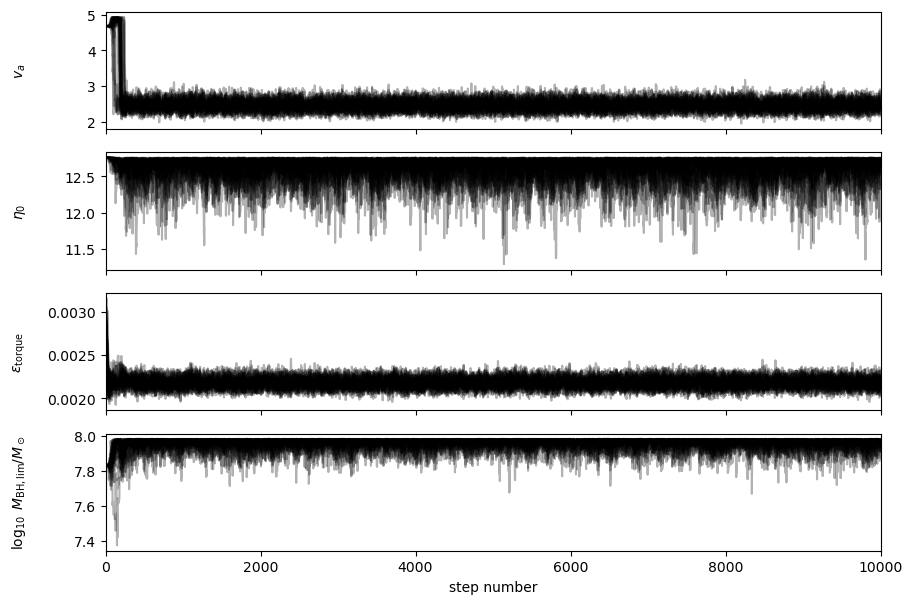

In [73]:
# Plot MCMC chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = emulator_info[list(emulator_info.keys())[0]]['emulator'].model_specification.parameter_printable_names
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [74]:
acc = sampler.acceptance_fraction
print("Mean acceptance fraction = %s" % np.mean(acc))

Mean acceptance fraction = 0.5055875000000001


In [75]:
# Get autocorrelation time to determine burn-in required (doesn't help too much, just look at plot of chains above)
tau = sampler.get_autocorr_time(quiet=True)
print(tau)

[171.90009299  81.1341207   55.01081625  95.56726114]


In [76]:
# Remove burn-in
# nburn = int(np.mean(tau))
# print(nburn)

# Can also just make burn-in X percent of number of iterations
x_percent = 0.1
nburn = int(x_percent * niter)
print(nburn)

#thin_val = int(nburn/100)
thin_val = 1

flat_samples = sampler.get_chain(discard=nburn, thin=thin_val, flat=True)

1000


In [77]:
# Posterior parameters with highest probability
theta_max_arr = flat_samples[np.argmax(sampler.get_log_prob(discard=nburn, thin=thin_val, flat=True))]
print(theta_max_arr)

[2.48869272e+00 1.27574287e+01 2.17837196e-03 7.98190418e+00]


GSMF



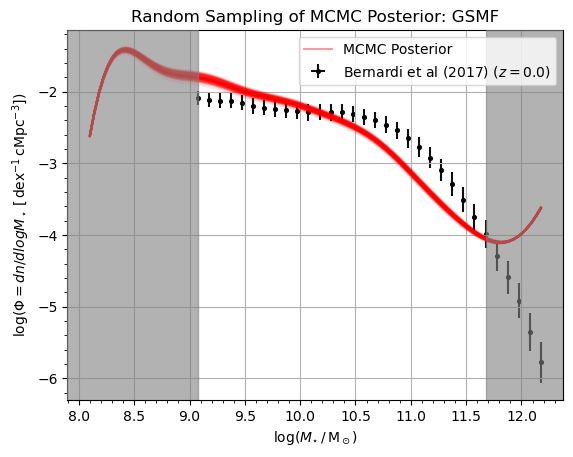

Theta max:  {'SIMBAFeedback:FIRE_velocity_normalization': 2.4886927239605168, 'SIMBAFeedback:FIRE_eta_normalization': 12.75742871127457, 'SIMBAAGN:torque_accretion_norm': 0.0021783719647658667, 'SIMBAAGN:jet_mass_min_Msun': 7.981904181649492}


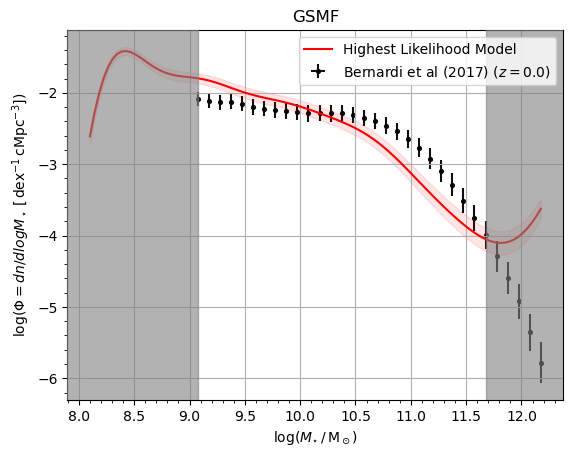




Mbh-M*



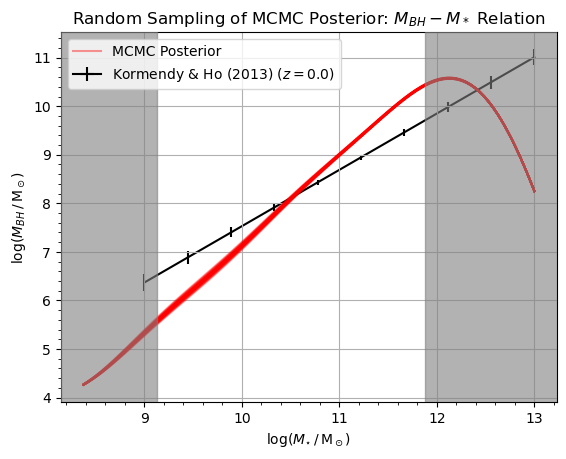

Theta max:  {'SIMBAFeedback:FIRE_velocity_normalization': 2.4886927239605168, 'SIMBAFeedback:FIRE_eta_normalization': 12.75742871127457, 'SIMBAAGN:torque_accretion_norm': 0.0021783719647658667, 'SIMBAAGN:jet_mass_min_Msun': 7.981904181649492}


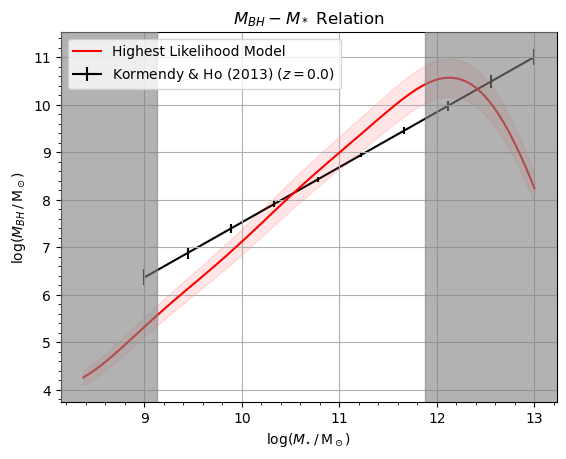

In [78]:
## Plot best-fit model from MCMC

shade_intensity = 0.6
zorder = 4

for key, item in emulator_info.items():
    print(key)
    print()
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']    
    
    
    
    
    # Extract random sampling of posteriors and plot over data
    plt.clf()
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
    
    
    for theta in flat_samples[np.random.randint(len(flat_samples), size=100)]:
#         pred_mcmc, pred_mcmc_err = model(theta, pred_x, item['emulator'])
        pred_mcmc, pred_mcmc_err = model(theta, pred_x, item)

        plt.plot(pred_x, pred_mcmc, color=item['plot_emu']['color'], 
                 ls='-', marker=item['plot_emu']['marker'], ms=2.5, alpha=0.1)

    plt.plot([],[], color=item['plot_emu']['color'], alpha=0.4, label='MCMC Posterior')
    
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation,
#                                                                        'zorder':10000,
                                                                      })
    
    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Random Sampling of MCMC Posterior: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Posterior parameters with highest probability
#     best_fit_model, best_fit_model_err = model(theta_max_arr, pred_x, item['emulator'])
    best_fit_model, best_fit_model_err = model(theta_max_arr, pred_x, item)

    theta_max = {}
    for param in emulator.parameter_order:
        idx = item['emulator'].parameter_order.index(param)
        theta_max[param] = theta_max_arr[idx]
    
    item['theta_max_arr'] = theta_max_arr
    item['theta_max'] = theta_max
    print ('Theta max: ', theta_max)
    
    
    
    # Plot best-fit model over data
    plt.clf()
    
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
    
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, best_fit_model, yerr=best_fit_model_err,
                     color="r", alpha=1, marker=item['plot_emu']['marker'], ms=3, label='Highest Likelihood Model')
    if item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, best_fit_model, label='Highest Likelihood Model', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, best_fit_model-best_fit_model_err, best_fit_model+best_fit_model_err, 
                         alpha=0.1, color=item['plot_emu']['color'])
        
        
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
        

    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title( item['emulator'].model_specification.sim_info['name'])
    
#     if key=='CSFH':
#         plt.ylim(-3, 0)
    
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    print()
    print()
    print()

Quantiles:
[(0.16, 2.3310055865464707), (0.5, 2.4611297131348886), (0.84, 2.600064388522475)]
Quantiles:
[(0.16, 12.512087137751672), (0.5, 12.66332305487863), (0.84, 12.734226694339446)]
Quantiles:
[(0.16, 0.0021256834336818254), (0.5, 0.002181135110848148), (0.84, 0.002237703884995639)]
Quantiles:
[(0.16, 7.935141995669263), (0.5, 7.964620340657286), (0.84, 7.978089364812012)]


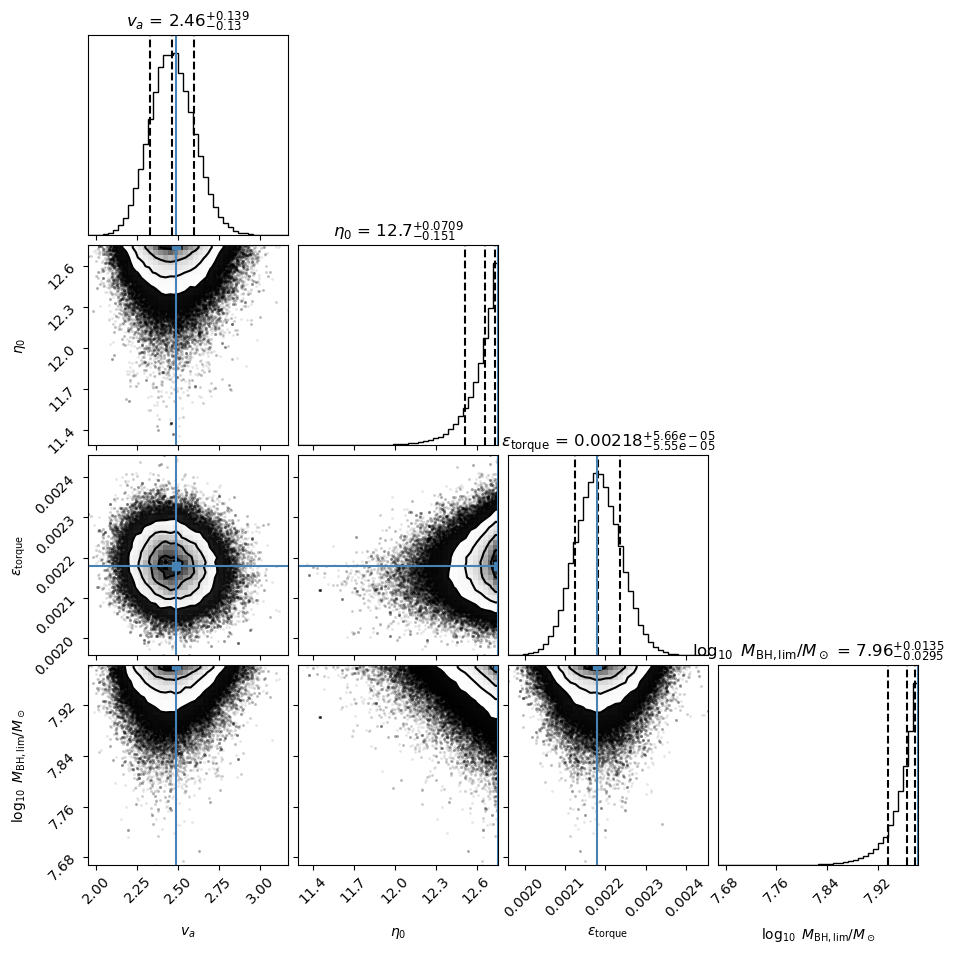

In [79]:
# Corner plot
labels = emulator_info[list(emulator_info.keys())[0]]['emulator'].model_specification.parameter_printable_names
fig = corner.corner(flat_samples, bins=40, hist_bin_factor=1, group='posterior', divergences=False, show_titles=True,
                    title_fmt='.3g', labels=labels, plot_datapoints=True, quantiles=[0.16,0.5,0.84],
                    title_quantiles=[0.16,0.5,0.84], smooth=0., verbose=True, use_math_text=True, reverse=False, 
                    truths=emulator_info[list(emulator_info.keys())[0]]['theta_max_arr'])

# Plot best fit results from observables (that have emulators) not included in above calibration

In [59]:
emulator_info_extra = {
    'GSMF':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
        'cali_dir':'calibrations',
#         'obs_name':'allMstar_gsmf_log_data_0015',
        'obs_name':'gsmf_log_data_min10gal_0015_allMstar',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s50n512',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/gsmf/Bernardi+17/',
        'data_name':'bernardi17_z0_gsmf_log_data_big_error_corrected',
        'data_choice':'data_sim',
        'use_err':'max',
        'min_x_for_mcmc':8.5,
        'max_x_for_mcmc':15,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue', 'err_bar_or_band':'band'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red', 'err_bar_or_band':'band'},
        'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'bar'},
    },
    'Mbh-M*':{
        'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
        'cali_dir':'calibrations',
#         'obs_name':'allMstar_bhmsm_binned_log_median_0015',
        'obs_name':'bhmsm_binned_log_median_min10gal_0015_lowMstar8.2',
        'emulator_type':'emulator',
        'snap_prefix':'simba_s50n512',
        'snap_num':'0015',
        'emulator_dir':'emulators',
        'data_dir':'/home/b/babul/aspadawe/data/observations/bhmsm/KormendyHo2013/',
        'data_name':'kh13_bhmsm_log_fit_og',
#         'data_name':'kh13_bhmsm_log_data',
        'data_choice':'data_interp',
        'use_err':'max',
        'min_x_for_mcmc':8.5,
        'max_x_for_mcmc':15,
        'plot_sim':{'ls':'--', 'marker':None, 'color':'blue', 'err_bar_or_band':'band'},
        'plot_emu':{'ls':'-', 'marker':None, 'color':'red', 'err_bar_or_band':'band'},
        'plot_data':{'ls':'-', 'marker':None, 'color':'black', 'err_bar_or_band':'band'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'bar'},
    },
#     'Quenched Fraction':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s50n512_ps2020_sphenix_32x/',
#         'cali_dir':'calibrations',
#         'obs_name':'lowMstar11_quenched_fraction_v2_0015_polynomial_degree_4',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s50n512',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/ssfr/gswlc-x2/',
#         'data_name':'gswlc-x2_ssfr_lowMstar11_quenched_fraction_v2',
#         'data_choice':'data_lim',
#         'use_err':'max',
#         'min_x_for_mcmc':1,
#         'max_x_for_mcmc':20,
#         'plot_sim':{'ls':'', 'marker':'o', 'color':'blue', 'err_bar_or_band':'bar'},
#         'plot_emu':{'ls':'', 'marker':'o', 'color':'red', 'err_bar_or_band':'bar'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'bar'},
#     },
#     'CSFH':{
#         'root_dir':'/scratch/b/babul/aspadawe/swift_tests/cali_simba/past_calibrations/swimba_s25n256_ps2020_32x_v2/',
#         'cali_dir':'calibrations',
#         'obs_name':'csfh_log_data',
#         'emulator_type':'emulator',
#         'snap_prefix':'simba_s25n256',
#         'snap_num':'0015',
#         'emulator_dir':'emulators',
#         'data_dir':'/home/b/babul/aspadawe/data/observations/csfh/MD14/',
#         'data_name':'md14_csfh_log_data',
#         'data_choice':'data_lim',
#         'use_err':'max',
#         'min_x_for_mcmc':-1,
#         'max_x_for_mcmc':5,
#         'plot_sim':{'ls':'--', 'marker':None, 'color':'blue', 'err_bar_or_band':'band'},
#         'plot_emu':{'ls':'-', 'marker':None, 'color':'red', 'err_bar_or_band':'band'},
#         'plot_data':{'ls':'', 'marker':'o', 'color':'black', 'err_bar_or_band':'band'},
#     },
}

In [60]:
# Get all relevant info for each observable
for key, item in emulator_info_extra.items():
    print(key)
    
    # Trained emulator
    with open(os.path.join(item['root_dir'], item['emulator_dir'], item['emulator_type']+'_'+item['obs_name']+'.pkl'), 'rb') as f:
        emulator = dill.load(f)
    item['emulator'] = emulator
    
    # Observational data
    observational_data = load_observations(os.path.join(item['data_dir'], item['data_name']+'.hdf5'))[0]
#     print(observational_data.x)
    
    sim_x_units = emulator.model_specification.sim_info['x_units']
    sim_y_units = emulator.model_specification.sim_info['y_units']
    data_x_units = observational_data.x_units
    data_y_units = observational_data.y_units
    
#     print(sim_y_units)
#     print(data_y_units)
    
    observational_data.x.convert_to_units(sim_x_units)
    observational_data.y.convert_to_units(sim_y_units)
    
#     observational_data = observational_data_[0]
#     print(observational_data)
    item['observational_data'] = observational_data
    
    
    # Penalty function
    sim_paths = [Path(x) for x in glob(os.path.join(item['root_dir'], item['cali_dir'], 'cali_*', 
                                                    item['snap_prefix']+'_'+item['obs_name']+'_'+item['snap_num']+'.hdf5')) 
                 if os.path.exists(x)]
    item['sim_paths'] = sim_paths
    

    penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=50,
                                                                                 sigma_max=100,
                                                                                 weight=100,
                                                                                 lower=min(observational_data.x),
                                                                                 upper=max(observational_data.x))
#     penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=0.01,
#                                                                                  sigma_max=0.1,
#                                                                                  weight=1,
#                                                                                  lower=min(observational_data.x),
#                                                                                  upper=max(observational_data.x))

    penalty_calculator.register_observation(observational_data,
                                log_independent=False,
                                log_dependent=False,
                                independent_units=observational_data.x_units,
                                dependent_units=observational_data.y_units)
    
    item['penalty_calculator'] = penalty_calculator
    
    
    
    # Get full range of x values that have been used in training emulator
    sim_x = []
    for cali in emulator.model_values.model_values:
        sim_x_curr = emulator.model_values[cali]['independent']
        for x_val in sim_x_curr:
            if x_val not in sim_x:
                sim_x.append(x_val)

    sim_x = np.array(np.sort(sim_x))
    item['sim_x'] = sim_x
    
    
    # Get "limited" range of x values that have been used in training emulator
    # ie. lower and upper limits on x values are ones that are common to all simulations
    sim_x_lim = []
    counter = 0
    for cali, item_ in emulator.model_values.items():
        sim_x_lim_curr = item_['independent']
        if counter==0:
            sim_x_lim = sim_x_lim_curr
        else:
            sim_x_lim = np.intersect1d(sim_x_lim, sim_x_lim_curr)
        counter += 1

    sim_x_lim = np.array(np.sort(sim_x_lim))
    item['sim_x_lim'] = sim_x_lim
    
    
    
    # Get just full range of data
    x = penalty_calculator.observation.x.value
#     xerr = penalty_calculator.observation.x_scatter.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
#     xerr = xerr[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]
    
    if item['use_err'] == 'max':
        data_full = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_full = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_full'] = data_full
    
    
    # Separate out data into x, y, yerr
    # Get only data that falls within chosen x range of simulation, but is still original data without interpolation
    x = penalty_calculator.observation.x.value
#     xerr = penalty_calculator.observation.x_scatter.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value
    
    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
#     xerr = xerr[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]

    range_condition = np.logical_and(x >= min(sim_x), x <= max(sim_x))
    x = x[range_condition]
#     xerr = xerr[range_condition]
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_sim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_sim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_sim'] = data_sim
    
    
    # Separate out data into x, y, yerr
    # Get only data that falls within limited x range of simulation, but is still original data without interpolation
    x = penalty_calculator.observation.x.value
#     xerr = penalty_calculator.observation.x_scatter.value
    y = penalty_calculator.observation.y.value
    yerr = penalty_calculator.observation.y_scatter.value
    
    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr

    sort_condition = np.argsort(x)
    x = x[sort_condition]
#     xerr = xerr[sort_condition]
    y = y[sort_condition]
    mean_yerr = mean_yerr[sort_condition]
    max_yerr = max_yerr[sort_condition]

    range_condition = np.logical_and(x >= min(sim_x_lim), x <= max(sim_x_lim))
    x = x[range_condition]
#     xerr = xerr[range_condition]
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_lim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_lim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_lim'] = data_lim
    
    
    # Separate out data into x, y, yerr
    # Get only data that corresponds to exact chosen x range of simulation
    # (Need to use GaussianDataErrorsPercentFloorPenaltyCalculator to do interpolation for this)
    x = sim_x
#     xerr = np.zeros()
    penalty_calculator.observation_interpolation()
    y = penalty_calculator.interpolator_values(x)
    yerr = penalty_calculator.error_interpolator_values(x)  # can only use for certain penalty calculators, eg. GaussianDataErrorsPercentFloorPenaltyCalculator

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr
        
    range_condition = np.logical_and(sim_x >= min(penalty_calculator.observation.x.value), 
                                     sim_x <= max(penalty_calculator.observation.x.value))
    x = x[range_condition]  # limit to within range of observational data
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_interp = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_interp = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_interp'] = data_interp
    
    
    
    # Separate out data into x, y, yerr
    # Get only data that corresponds to exact limited x range of simulation
    # (Need to use GaussianDataErrorsPercentFloorPenaltyCalculator to do interpolation for this)
    x = sim_x_lim
    penalty_calculator.observation_interpolation()
    y = penalty_calculator.interpolator_values(x)
    yerr = penalty_calculator.error_interpolator_values(x)  # can only use for certain penalty calculators, eg. GaussianDataErrorsPercentFloorPenaltyCalculator

    if (yerr.ndim!=1):
        mean_yerr = np.nanmean(yerr, axis=0)
        max_yerr = np.nanmax(yerr, axis=0)
    else:
        mean_yerr = yerr
        max_yerr = yerr
        
    range_condition = np.logical_and(sim_x_lim >= min(penalty_calculator.observation.x.value), 
                                     sim_x_lim <= max(penalty_calculator.observation.x.value))
    x = x[range_condition]  # limit to within range of observational data
    y = y[range_condition]
    mean_yerr = mean_yerr[range_condition]
    max_yerr = max_yerr[range_condition]

    if item['use_err'] == 'max':
        data_interp_lim = (x, y, max_yerr)
    elif item['use_err'] == 'mean':
        data_interp_lim = (x, y, mean_yerr)
    else:
        print("Invalid error choice")
        break
    item['data_interp_lim'] = data_interp_lim
    
    
    
    # Choose which data to use for MCMC
    try:
        data_choice = item[item['data_choice']]
    except:
        print('Invalid data choice')
        break
    range_condition = np.logical_and(data_choice[0] >= item['min_x_for_mcmc'], 
                                     data_choice[0] <= item['max_x_for_mcmc'])
    x = data_choice[0][range_condition]
    y = data_choice[1][range_condition]
    yerr = data_choice[2][range_condition]
    
    data_for_mcmc = (x, y, yerr)
    item['data_for_mcmc'] = data_for_mcmc
    
    
    
    
    # Limit observational data to data_for_mcmc
    item['observational_data_for_mcmc'] = copy(item['observational_data'])
    item['observational_data_for_mcmc'].associate_x(item['data_for_mcmc'][0]*item['observational_data'].x_units, 
                                           scatter=np.zeros(len(item['data_for_mcmc'][0]))*item['observational_data'].x_units, 
                                           comoving=item['observational_data'].x_comoving, 
                                           description=item['observational_data'].x_description)
    item['observational_data_for_mcmc'].associate_y(item['data_for_mcmc'][1]*item['observational_data'].y_units, 
                                           scatter=item['data_for_mcmc'][2]*item['observational_data'].y_units, 
                                           comoving=item['observational_data'].y_comoving, 
                                           description=item['observational_data'].y_description)
    
#     print(item['observational_data'].x)
#     print(item['observational_data'].x_description)
    
    
    # Re-initialize penalty calculator so it only considers data_for_mcmc
    penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=50,
                                                                                 sigma_max=100,
                                                                                 weight=100,
                                                                                 lower=min(item['observational_data_for_mcmc'].x),
                                                                                 upper=max(item['observational_data_for_mcmc'].x))
#     penalty_calculator = GaussianWeightedDataErrorsPercentFloorPenaltyCalculator(percent_error=0.01,
#                                                                                  sigma_max=0.1,
#                                                                                  weight=1,
#                                                                                  lower=min(observational_data.x),
#                                                                                  upper=max(observational_data.x))
#     penalty_calculator = L2PenaltyCalculator(offset=0.5,
#                                              lower=min(item['observational_data'].x),
#                                              upper=max(item['observational_data'].x))

    penalty_calculator.register_observation(item['observational_data_for_mcmc'],
                                log_independent=False,
                                log_dependent=False,
                                independent_units=item['observational_data_for_mcmc'].x_units,
                                dependent_units=item['observational_data_for_mcmc'].y_units)
    
    item['penalty_calculator_for_mcmc'] = penalty_calculator
    
    
    
    
    # Get full x range of both simulation and observational data (just for plotting purposes)
    x_lo_full = min(min(sim_x), min(data_full[0]))
    x_hi_full = max(max(sim_x), max(data_full[0]))
    
    N_full = 100
    x_full = np.linspace(x_lo_full, x_hi_full, N_full)
    item['x_full'] = x_full
    
    
    
    # Check which input simulation best fits the observational data
    all_penalties = item['penalty_calculator_for_mcmc'].penalties(emulator.model_values, np.mean)
#     print(all_penalties)

    all_penalties_array = []
    node_number = []
    for key_penalty in all_penalties.keys():
        all_penalties_array.append(all_penalties[key_penalty])
        node_number.append(key_penalty)

#     print(all_penalties_array)
#     print(np.min(all_penalties_array))
    best_node = node_number[np.argmin(all_penalties_array)]
#     best_node = node_number[np.argmax(all_penalties_array)]
    params_best_node = emulator.model_parameters[best_node].copy()
    
    item['best_node'] = best_node
    item['params_best_node'] = params_best_node
#     print(best_node)
#     print(params_best_node)
    
    
    # Get min and max values of each parameter that go into original simulations
    # They will be the MCMC parameter limits
    param_mins_arr = []
    param_maxs_arr = []
    param_mins = {}
    param_maxs = {}
    
    for param_, param_limits_ in zip(emulator.model_specification.parameter_names, emulator.model_specification.parameter_limits):
        param_mins_arr.append(param_limits_[0])
        param_maxs_arr.append(param_limits_[1])
    param_mins_arr = np.array(param_mins_arr, float)
    param_maxs_arr = np.array(param_maxs_arr, float)
    
    # If you want to specify other flat parameter priors for the MCMC
#     param_mins_arr = [0.5, 5.0, 0.00001, 6.5]
#     param_maxs_arr = [5.0, 13.0, 0.008, 8.0]

    for param_, param_limits_ in zip(emulator.model_specification.parameter_names, emulator.model_specification.parameter_limits):
        param_mins[param_] = param_limits_[0]
        param_maxs[param_] = param_limits_[1]
    
    item['param_mins'] = param_mins
    item['param_maxs'] = param_maxs
    item['param_mins_arr'] = param_mins_arr
    item['param_maxs_arr'] = param_maxs_arr
    
    
    
    print("DONE")
    print()

GSMF
DONE

Mbh-M*
DONE



GSMF
Best simulation: cali_0025
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.342729786319703, 'SIMBAFeedback:FIRE_eta_normalization': 9.890361171833192, 'SIMBAAGN:torque_accretion_norm': 0.0015035993220772544, 'SIMBAAGN:jet_mass_min_Msun': 7.9529521605643065}


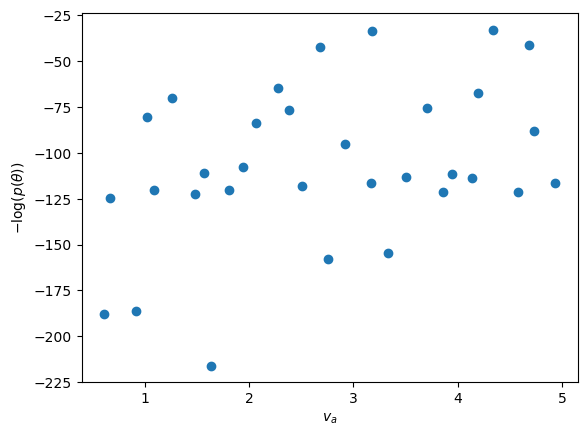

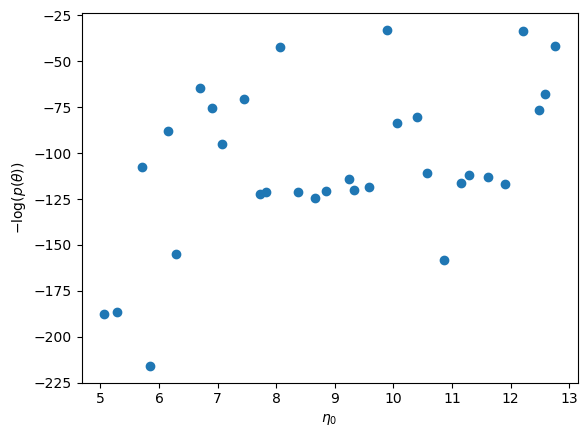

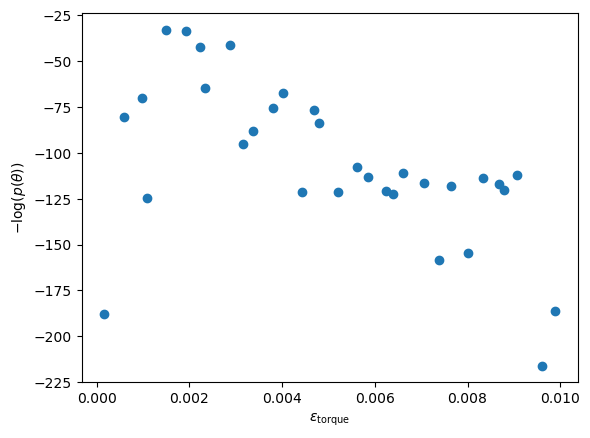

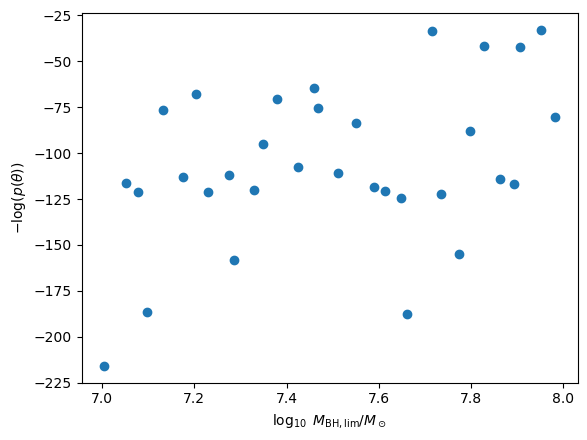


Mbh-M*
Best simulation: cali_0024
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


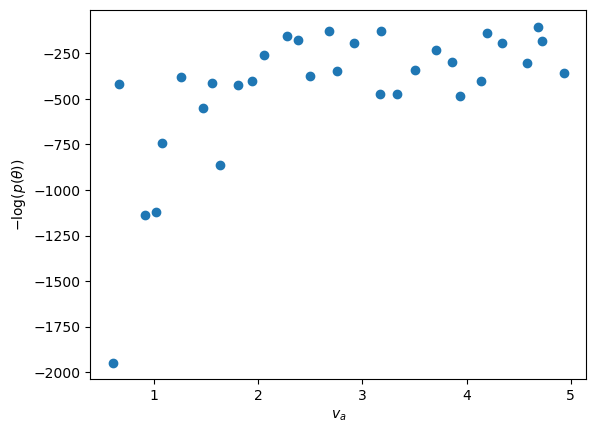

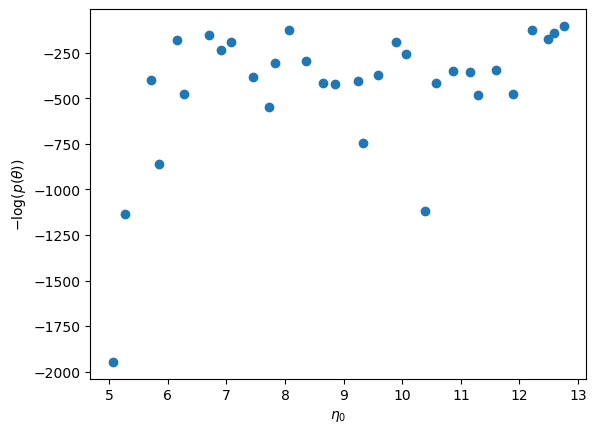

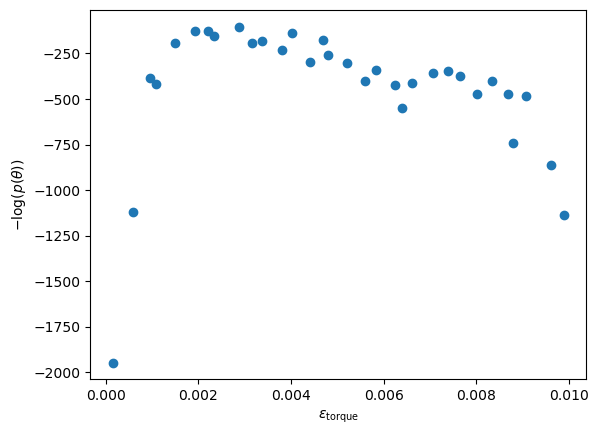

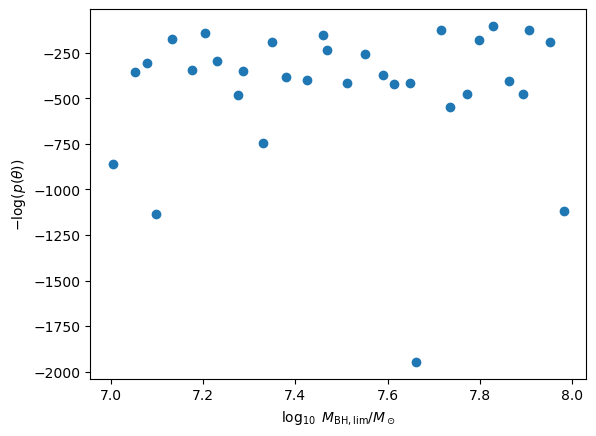


Quenched Fraction
Best simulation: cali_0003
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.727477736838244, 'SIMBAFeedback:FIRE_eta_normalization': 6.151178263359965, 'SIMBAAGN:torque_accretion_norm': 0.0033789370604987187, 'SIMBAAGN:jet_mass_min_Msun': 7.797660082334008}


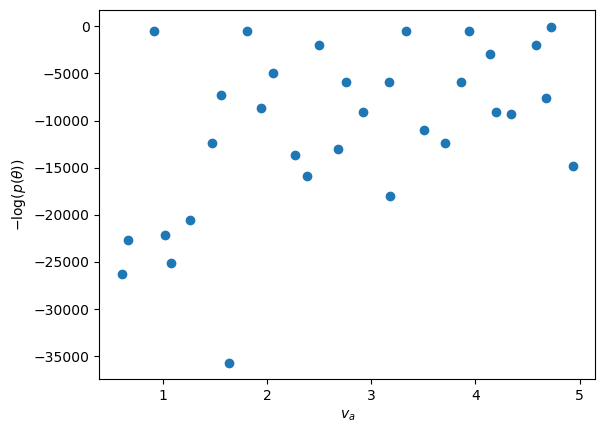

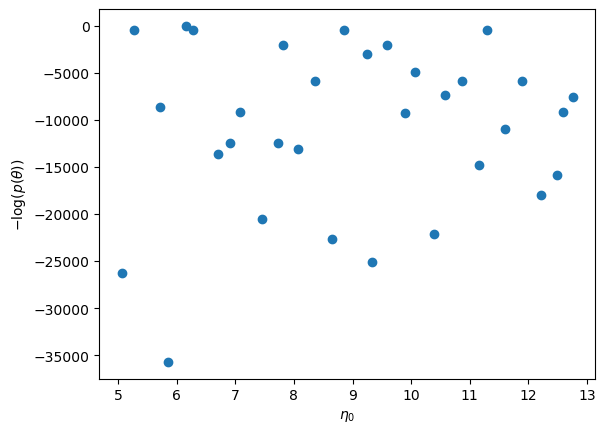

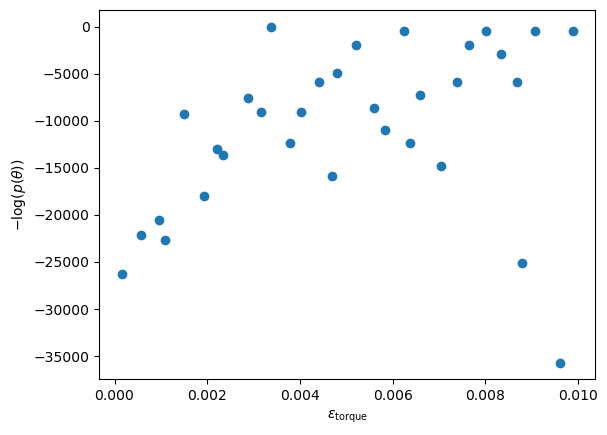

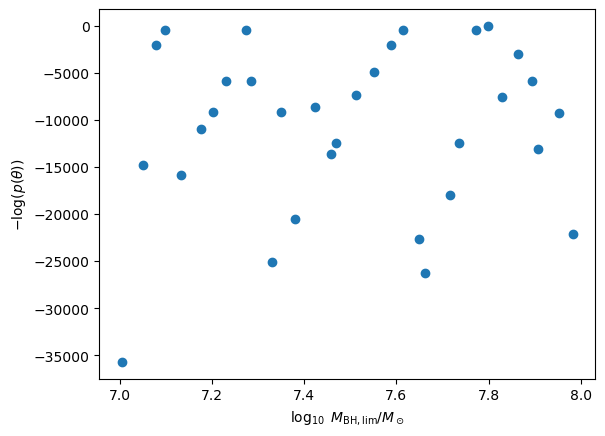

In [42]:
# Find best-fit simulations individually (ie. not jointly), but using my likelihood definition, which does not have issues

best_sim_ind_dict = {}
params_best_sim_ind_dict = {}

for key, info in emulator_info_extra.items():
    print(key)

    sim_calis = []
    sim_thetas = []
    sim_likelihood = []
    for cali_, params_ in info['emulator'].model_parameters.model_parameters.items():
        theta_ = np.array(list(params_.values()))
    #     print(cali_)
    #     print(theta_)
        sim_calis.append(cali_)
        sim_thetas.append(theta_)
        sim_likelihood.append(sim_lnprob(cali_, theta_, {key:info}))

    sim_likelihood = np.array(sim_likelihood)

    best_sim_ind = sim_calis[np.argmax(sim_likelihood)]
    params_best_sim_ind = info['emulator'].model_parameters[best_sim_ind].copy()
    best_sim_ind_dict[key] = best_sim_ind
    params_best_sim_ind_dict[key] = params_best_sim_ind
    print('Best simulation:', best_sim_ind)
    print('Best simulation parameters:', params_best_sim_ind)

    sim_thetas_arr = np.zeros((len(sim_thetas), len(sim_thetas[0])))
    for ii in range(len(sim_thetas)):
        theta_ = sim_thetas[ii]
        sim_thetas_arr[ii,:] = theta_

    for jj in range(info['emulator'].model_specification.number_of_parameters):
    #     plt.hist(sim_thetas_arr[:,jj])
        plt.scatter(sim_thetas_arr[:,jj], sim_likelihood)
    #     plt.bar(sim_thetas_arr[:,jj], sim_likelihood)
        plt.xlabel(r'%s' % info['emulator'].model_specification.parameter_printable_names[jj])
        plt.ylabel(r'$-\log(p(\theta))$')
        plt.show()
        
    print()

GSMF

Best individual simulation: cali_0025
Best individual simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.342729786319703, 'SIMBAFeedback:FIRE_eta_normalization': 9.890361171833192, 'SIMBAAGN:torque_accretion_norm': 0.0015035993220772544, 'SIMBAAGN:jet_mass_min_Msun': 7.9529521605643065}


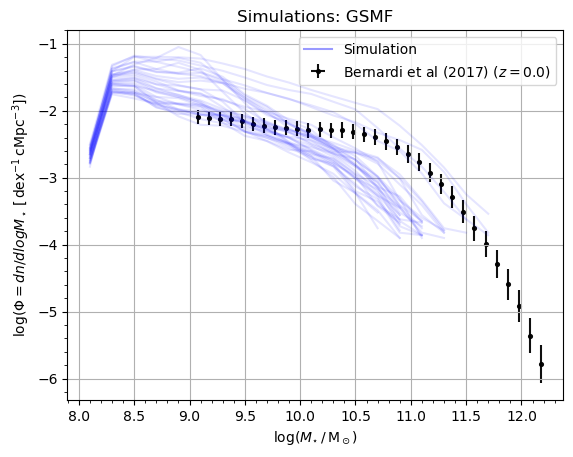

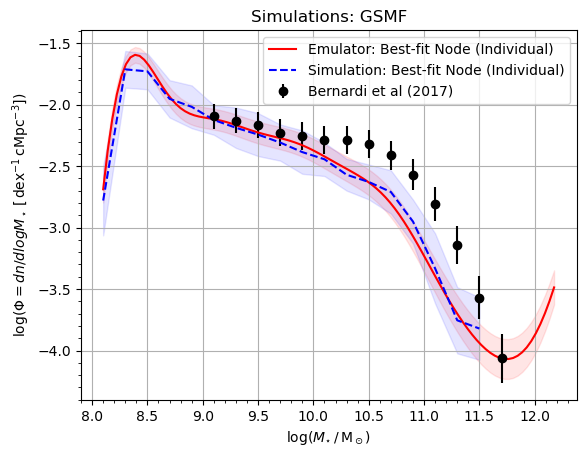

Mbh-M*

Best individual simulation: cali_0024
Best individual simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


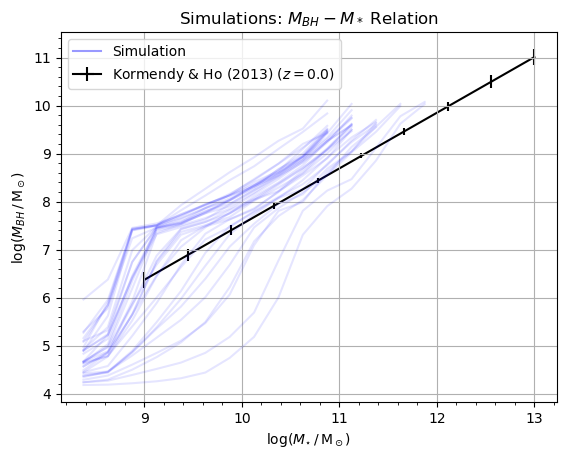

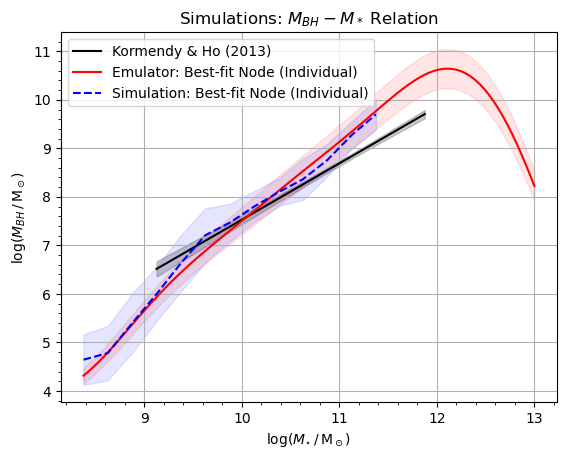

Quenched Fraction

Best individual simulation: cali_0003
Best individual simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.727477736838244, 'SIMBAFeedback:FIRE_eta_normalization': 6.151178263359965, 'SIMBAAGN:torque_accretion_norm': 0.0033789370604987187, 'SIMBAAGN:jet_mass_min_Msun': 7.797660082334008}


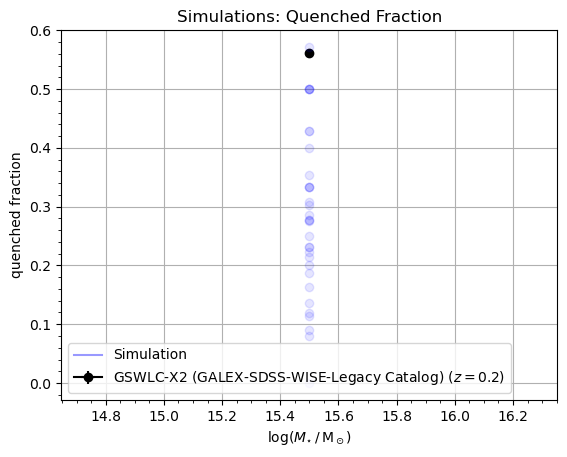

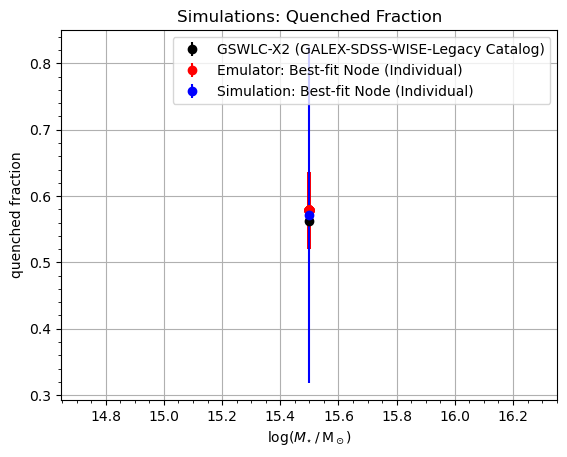

In [43]:
## Plot these best-fit simulations with their observational data

for key, item in emulator_info_extra.items():
    print(key)
    print()
    
    print('Best individual simulation:', best_sim_ind_dict[key])
    print('Best individual simulation parameters:', params_best_sim_ind_dict[key])
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    
    
    
    
    # Plot simulated observables over observational data
    plt.clf()
    
#     item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']
        
        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], 
                 color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    
#     item['observational_data_for_mcmc'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    if item['plot_data']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['data_interp'][0], item['data_interp'][1], yerr=item['data_interp'][2], 
                     color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                     label=item['observational_data'].citation)
    elif item['plot_data']['err_bar_or_band'] == 'band':
        plt.plot(item['data_interp'][0], item['data_interp'][1],
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
                 marker=item['plot_data']['marker'], label=item['observational_data'].citation)
        plt.fill_between(item['data_interp'][0], 
                         item['data_interp'][1] - item['data_interp'][2], 
                         item['data_interp'][1] + item['data_interp'][2], 
                         color=item['plot_data']['color'], alpha=0.2)
    
    
#     pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
    
#     if item['plot_emu']['err_bar_or_band'] == 'bar':
#         plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node', 
#                      color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#     elif item['plot_emu']['err_bar_or_band'] == 'band':
#         plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
#                  color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#         plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
#     if item['plot_sim']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
#                      item['emulator'].model_values[item['best_node']]['dependent'],
#                      yerr=item['emulator'].model_values[item['best_node']]['dependent_error'],
#                      label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                      ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#     elif item['plot_sim']['err_bar_or_band'] == 'band':
#         plt.plot(item['emulator'].model_values[item['best_node']]['independent'],
#                  item['emulator'].model_values[item['best_node']]['dependent'],
#                  label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                  ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#         plt.fill_between(item['emulator'].model_values[item['best_node']]['independent'],
#                          item['emulator'].model_values[item['best_node']]['dependent']-item['emulator'].model_values[item['best_node']]['dependent_error'],
#                          item['emulator'].model_values[item['best_node']]['dependent']+item['emulator'].model_values[item['best_node']]['dependent_error'], 
#                          alpha=0.1, color=item['plot_sim']['color'])
        
        
        
    
    pred_y, pred_err = emulator_model(pred_x, params_best_sim_ind_dict[key], item['emulator'])
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node (Individual)', 
                     color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    elif item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node (Individual)', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    if item['plot_sim']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['emulator'].model_values[best_sim_ind_dict[key]]['independent'], 
                     item['emulator'].model_values[best_sim_ind_dict[key]]['dependent'],
                     yerr=item['emulator'].model_values[best_sim_ind_dict[key]]['dependent_error'],
                     label='Simulation: Best-fit Node (Individual)', color=item['plot_sim']['color'], 
                     ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
    elif item['plot_sim']['err_bar_or_band'] == 'band':
        plt.plot(item['emulator'].model_values[best_sim_ind_dict[key]]['independent'],
                 item['emulator'].model_values[best_sim_ind_dict[key]]['dependent'],
                 label='Simulation: Best-fit Node (Individual)', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
        plt.fill_between(item['emulator'].model_values[best_sim_ind_dict[key]]['independent'],
                         item['emulator'].model_values[best_sim_ind_dict[key]]['dependent']-item['emulator'].model_values[best_sim_ind_dict[key]]['dependent_error'],
                         item['emulator'].model_values[best_sim_ind_dict[key]]['dependent']+item['emulator'].model_values[best_sim_ind_dict[key]]['dependent_error'], 
                         alpha=0.1, color=item['plot_sim']['color'])
        
        

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Find best simulation by looking at joint likelihood

Best simulation: cali_0024
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}


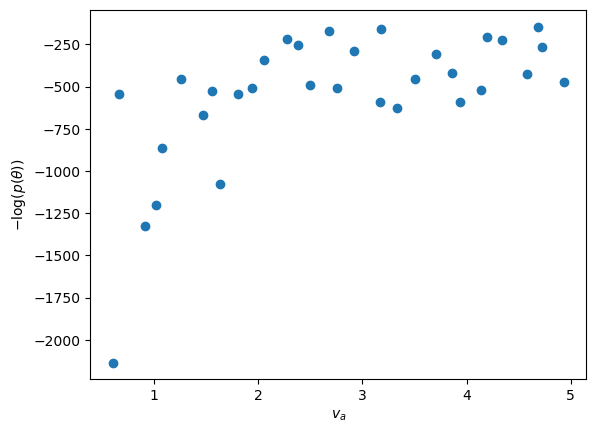

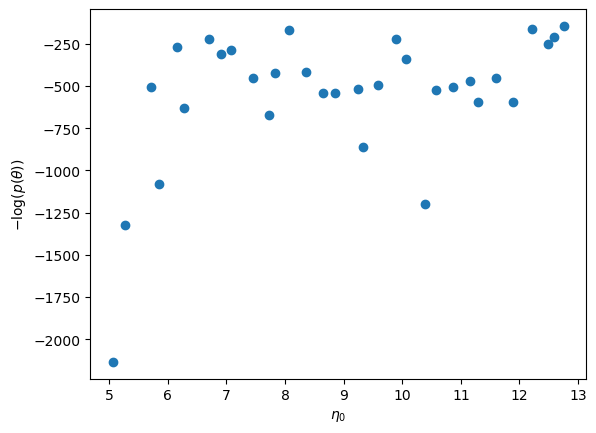

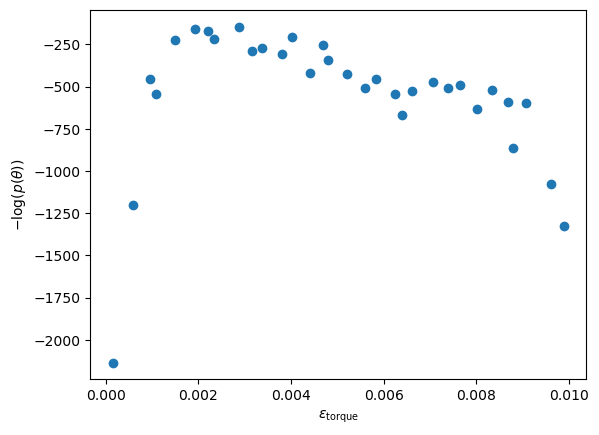

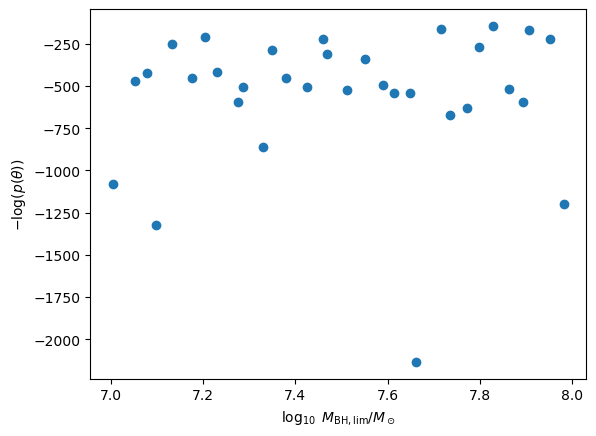

In [65]:
## Find single best-fit simulation with all observational datasets jointly
## This is what probably should be used as the initial parameters for the MCMC

sim_calis_extra = []
sim_thetas_extra = []
sim_likelihood_extra = []
for cali_, params_ in emulator_info_extra[list(emulator_info_extra.keys())[0]]['emulator'].model_parameters.model_parameters.items():
    theta_ = np.array(list(params_.values()))
#     print(cali_)
#     print(theta_)
    sim_calis_extra.append(cali_)
    sim_thetas_extra.append(theta_)
    sim_likelihood_extra.append(sim_lnprob(cali_, theta_, emulator_info_extra))
    
sim_likelihood_extra = np.array(sim_likelihood_extra)

best_sim_extra = sim_calis_extra[np.argmax(sim_likelihood_extra)]
params_best_sim_extra = emulator_info_extra[list(emulator_info_extra.keys())[0]]['emulator'].model_parameters[best_sim_extra].copy()
print('Best simulation:', best_sim_extra)
print('Best simulation parameters:', params_best_sim_extra)

sim_thetas_arr_extra = np.zeros((len(sim_thetas_extra), len(sim_thetas_extra[0])))
for ii in range(len(sim_thetas_extra)):
    theta_ = sim_thetas_extra[ii]
    sim_thetas_arr_extra[ii,:] = theta_
    
for jj in range(emulator_info_extra[list(emulator_info_extra.keys())[0]]['emulator'].model_specification.number_of_parameters):
#     plt.hist(sim_thetas_arr[:,jj])
    plt.scatter(sim_thetas_arr_extra[:,jj], sim_likelihood)
#     plt.bar(sim_thetas_arr[:,jj], sim_likelihood)
    plt.xlabel(r'%s' % emulator_info_extra[list(emulator_info_extra.keys())[0]]['emulator'].model_specification.parameter_printable_names[jj])
    plt.ylabel(r'$-\log(p(\theta))$')
    plt.show()

Best simulation: cali_0024
Best simulation parameters: {'SIMBAFeedback:FIRE_velocity_normalization': 4.6802977676874455, 'SIMBAFeedback:FIRE_eta_normalization': 12.75773436560765, 'SIMBAAGN:torque_accretion_norm': 0.0028704300945964897, 'SIMBAAGN:jet_mass_min_Msun': 7.829541525859594}

GSMF



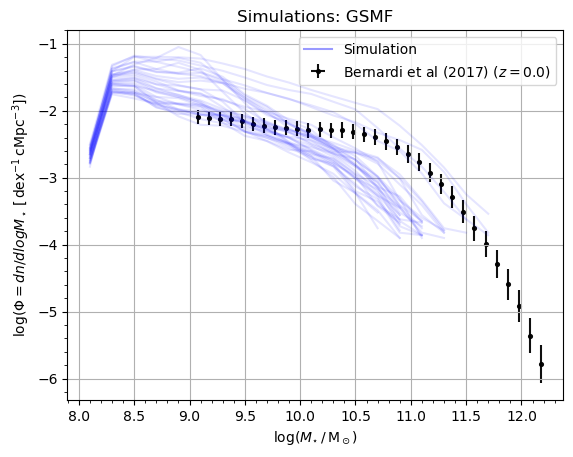

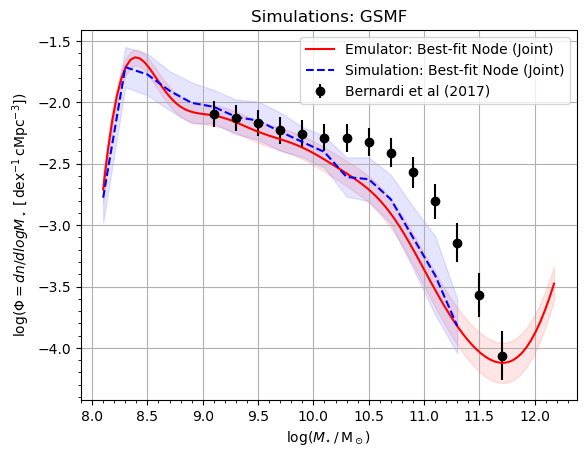

Mbh-M*



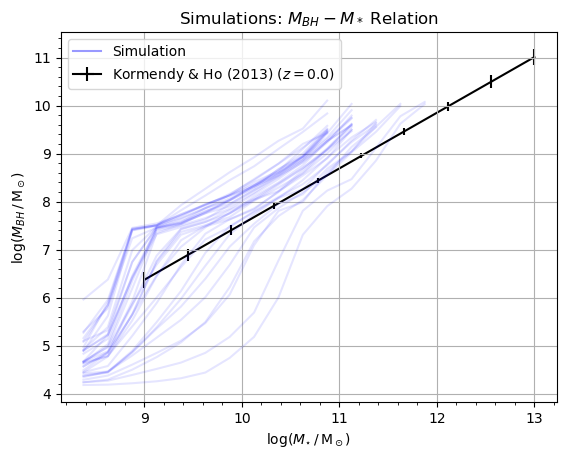

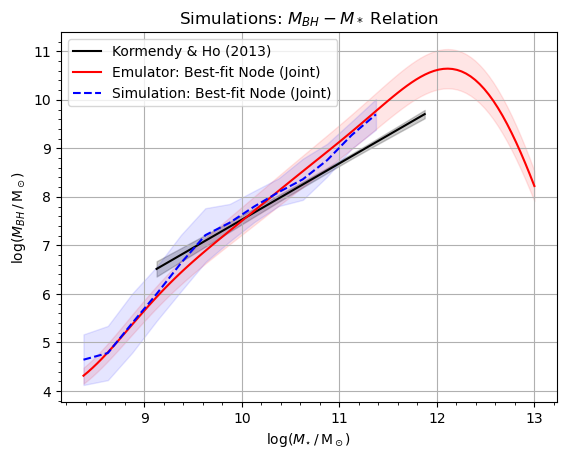

In [66]:
## Plot this best-fit simulation

print('Best simulation:', best_sim_extra)
print('Best simulation parameters:', params_best_sim_extra)
print()

for key, item in emulator_info_extra.items():
    print(key)
    print()
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']
    
    
    
    
    
    
    # Plot simulated observables over observational data
    plt.clf()
    
#     item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
        
    for cali, cali_item in item['emulator'].model_values.items():
        sim_x_cali = cali_item['independent']
        sim_y_cali = cali_item['dependent']
        
        plt.plot(sim_x_cali, sim_y_cali,
                 ls='-', marker=item['plot_sim']['marker'], 
                 color=item['plot_sim']['color'], alpha=0.1)

    plt.plot([],[], color=item['plot_sim']['color'], alpha=0.4, label='Simulation')
    
    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Plot best-fit simulation node over observational data
    plt.clf()
    
#     item['observational_data_for_mcmc'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
# #                                                                        'ls':item['plot_data']['ls'], 
#                                                                        'marker':item['plot_data']['marker'], 
# #                                                                        'label':item['observational_data'].citation
#                                                                       })
    
    if item['plot_data']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['data_interp'][0], item['data_interp'][1], yerr=item['data_interp'][2], 
                     color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
                     label=item['observational_data'].citation)
    elif item['plot_data']['err_bar_or_band'] == 'band':
        plt.plot(item['data_interp'][0], item['data_interp'][1],
                 color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
                 marker=item['plot_data']['marker'], label=item['observational_data'].citation)
        plt.fill_between(item['data_interp'][0], 
                         item['data_interp'][1] - item['data_interp'][2], 
                         item['data_interp'][1] + item['data_interp'][2], 
                         color=item['plot_data']['color'], alpha=0.2)
    
    
#     pred_y, pred_err = emulator_model(pred_x, item['params_best_node'], item['emulator'])
    
#     if item['plot_emu']['err_bar_or_band'] == 'bar':
#         plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node', 
#                      color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#     elif item['plot_emu']['err_bar_or_band'] == 'band':
#         plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node', 
#                  color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
#         plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
#     if item['plot_sim']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['emulator'].model_values[item['best_node']]['independent'], 
#                      item['emulator'].model_values[item['best_node']]['dependent'],
#                      yerr=item['emulator'].model_values[item['best_node']]['dependent_error'],
#                      label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                      ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#     elif item['plot_sim']['err_bar_or_band'] == 'band':
#         plt.plot(item['emulator'].model_values[item['best_node']]['independent'],
#                  item['emulator'].model_values[item['best_node']]['dependent'],
#                  label='Simulation: Best-fit Node', color=item['plot_sim']['color'], 
#                  ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
#         plt.fill_between(item['emulator'].model_values[item['best_node']]['independent'],
#                          item['emulator'].model_values[item['best_node']]['dependent']-item['emulator'].model_values[item['best_node']]['dependent_error'],
#                          item['emulator'].model_values[item['best_node']]['dependent']+item['emulator'].model_values[item['best_node']]['dependent_error'], 
#                          alpha=0.1, color=item['plot_sim']['color'])
        
        
        
    
    pred_y, pred_err = emulator_model(pred_x, params_best_sim_extra, item['emulator'])
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, pred_y, yerr=pred_err, label='Emulator: Best-fit Node (Joint)', 
                     color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
    elif item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, pred_y, label='Emulator: Best-fit Node (Joint)', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, pred_y-pred_err, pred_y+pred_err, alpha=0.1, color=item['plot_emu']['color'])
    
    if item['plot_sim']['err_bar_or_band'] == 'bar':
        plt.errorbar(item['emulator'].model_values[best_sim_extra]['independent'], 
                     item['emulator'].model_values[best_sim_extra]['dependent'],
                     yerr=item['emulator'].model_values[best_sim_extra]['dependent_error'],
                     label='Simulation: Best-fit Node (Joint)', color=item['plot_sim']['color'], 
                     ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
    elif item['plot_sim']['err_bar_or_band'] == 'band':
        plt.plot(item['emulator'].model_values[best_sim_extra]['independent'],
                 item['emulator'].model_values[best_sim_extra]['dependent'],
                 label='Simulation: Best-fit Node (Joint)', color=item['plot_sim']['color'], 
                 ls=item['plot_sim']['ls'], marker=item['plot_sim']['marker'])
        plt.fill_between(item['emulator'].model_values[best_sim_extra]['independent'],
                         item['emulator'].model_values[best_sim_extra]['dependent']-item['emulator'].model_values[best_sim_extra]['dependent_error'],
                         item['emulator'].model_values[best_sim_extra]['dependent']+item['emulator'].model_values[best_sim_extra]['dependent_error'], 
                         alpha=0.1, color=item['plot_sim']['color'])
        
        

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Simulations: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

GSMF



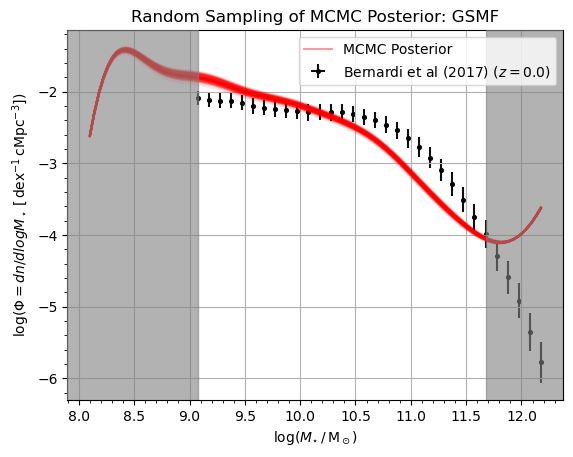

Theta max:  {'SIMBAFeedback:FIRE_velocity_normalization': 2.4886927239605168, 'SIMBAFeedback:FIRE_eta_normalization': 12.75742871127457, 'SIMBAAGN:torque_accretion_norm': 0.0021783719647658667, 'SIMBAAGN:jet_mass_min_Msun': 7.981904181649492}


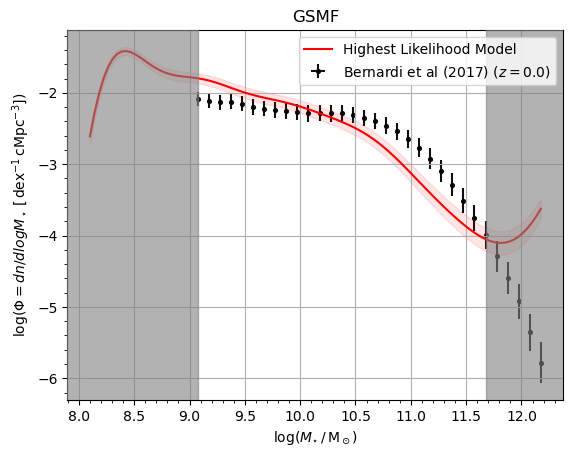




Mbh-M*



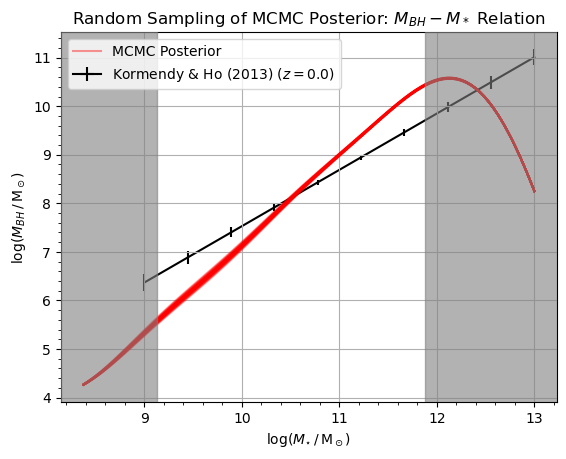

Theta max:  {'SIMBAFeedback:FIRE_velocity_normalization': 2.4886927239605168, 'SIMBAFeedback:FIRE_eta_normalization': 12.75742871127457, 'SIMBAAGN:torque_accretion_norm': 0.0021783719647658667, 'SIMBAAGN:jet_mass_min_Msun': 7.981904181649492}


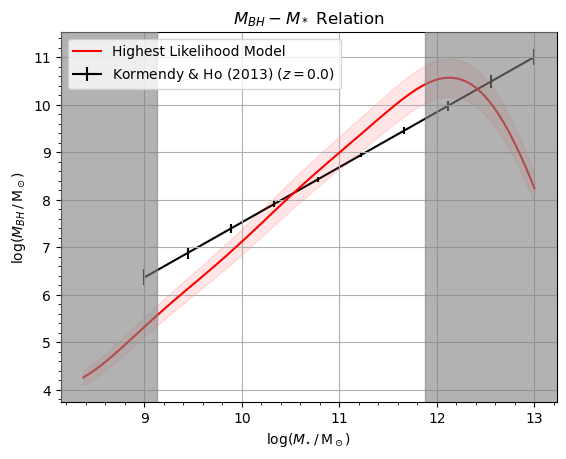

In [78]:
## Plot best-fit model from MCMC

shade_intensity = 0.6
zorder = 4

for key, item in emulator_info_extra.items():
    print(key)
    print()
    
    
#     pred_x = item['sim_x']
    pred_x = item['x_full']    
    
    
    
    
    # Extract random sampling of posteriors and plot over data
    plt.clf()
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
    
    
    for theta in flat_samples[np.random.randint(len(flat_samples), size=100)]:
#         pred_mcmc, pred_mcmc_err = model(theta, pred_x, item['emulator'])
        pred_mcmc, pred_mcmc_err = model(theta, pred_x, item)

        plt.plot(pred_x, pred_mcmc, color=item['plot_emu']['color'], 
                 ls='-', marker=item['plot_emu']['marker'], ms=2.5, alpha=0.1)

    plt.plot([],[], color=item['plot_emu']['color'], alpha=0.4, label='MCMC Posterior')
    
    
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation,
#                                                                        'zorder':10000,
                                                                      })
    
    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title('Random Sampling of MCMC Posterior: %s' % item['emulator'].model_specification.sim_info['name'])
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    
    
    # Posterior parameters with highest probability
#     best_fit_model, best_fit_model_err = model(theta_max_arr, pred_x, item['emulator'])
    best_fit_model, best_fit_model_err = model(theta_max_arr, pred_x, item)

    theta_max = {}
    for param in emulator.parameter_order:
        idx = item['emulator'].parameter_order.index(param)
        theta_max[param] = theta_max_arr[idx]
    
    item['theta_max_arr'] = theta_max_arr
    item['theta_max'] = theta_max
    print ('Theta max: ', theta_max)
    
    
    
    # Plot best-fit model over data
    plt.clf()
    
    
#     if item['plot_data']['err_bar_or_band'] == 'bar':
#         plt.errorbar(item['data_full'][0], item['data_full'][1], yerr=item['data_full'][2], 
#                      color=item['plot_data']['color'], ls=item['plot_data']['ls'], marker=item['plot_data']['marker'], 
#                      label=item['observational_data'].citation)
#     elif item['plot_data']['err_bar_or_band'] == 'band':
#         plt.plot(item['data_full'][0], item['data_full'][1],
#                  color=item['plot_data']['color'], ls=item['plot_data']['ls'], 
#                  marker=item['plot_data']['marker'], label=item['observational_data'].citation)
#         plt.fill_between(item['data_full'][0], 
#                          item['data_full'][1] - item['data_full'][2], 
#                          item['data_full'][1] + item['data_full'][2], 
#                          color=item['plot_data']['color'], alpha=0.2)
    
    
    if item['plot_emu']['err_bar_or_band'] == 'bar':
        plt.errorbar(pred_x, best_fit_model, yerr=best_fit_model_err,
                     color="r", alpha=1, marker=item['plot_emu']['marker'], ms=3, label='Highest Likelihood Model')
    if item['plot_emu']['err_bar_or_band'] == 'band':
        plt.plot(pred_x, best_fit_model, label='Highest Likelihood Model', 
                 color=item['plot_emu']['color'], ls=item['plot_emu']['ls'], marker=item['plot_emu']['marker'])
        plt.fill_between(pred_x, best_fit_model-best_fit_model_err, best_fit_model+best_fit_model_err, 
                         alpha=0.1, color=item['plot_emu']['color'])
        
        
    item['observational_data'].plot_on_axes(axes=plt, errorbar_kwargs={'color':item['plot_data']['color'], 
#                                                                        'ls':item['plot_data']['ls'], 
                                                                       'marker':item['plot_data']['marker'], 
#                                                                        'label':item['observational_data'].citation
                                                                      })
        

    left, right = plt.xlim()
    plt.xlim(left, right)
    plt.axvspan(left, min(item['data_for_mcmc'][0]), alpha=shade_intensity, color='gray', zorder=zorder)
    plt.axvspan(max(item['data_for_mcmc'][0]), right, alpha=shade_intensity, color='gray', zorder=zorder)

    plt.xlabel(item['emulator'].model_specification.sim_info['X_LABEL'])
    plt.ylabel(item['emulator'].model_specification.sim_info['Y_LABEL'])
    plt.title( item['emulator'].model_specification.sim_info['name'])
    
#     if key=='CSFH':
#         plt.ylim(-3, 0)
    
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()
    
    
    print()
    print()
    print()